In [39]:
K = GF(3)
FF.<t> = FunctionField(K)
P.<x,y> = ProjectiveSpace(FF,1)

In [40]:
# %load mod_dynamical_system_prime.py
# Function that return the dynamical system mod p ( ds mod p )
def mod(self,p):
    DS = copy(self)
    DS.normalize_coordinates()  # normalize coordinates of dynamical system
    df_p_all = DS.defining_polynomials()
    coefficients = [poly.coefficients() for poly in DS.defining_polynomials()]
    monomials = [poly.monomials() for poly in DS.defining_polynomials()]
    F = DS.base_ring() # obtain base_ring of dynamical system
    O = F.maximal_order()
    p = O.ideal(p).place()
    k, fr_k, to_k = p.residue_field()
    # reduce each coefficient of each polynomial using the function to_k :
    reduced_coefficients = []
    for coeff in coefficients:
        reduced_coefficients.append([to_k(c) for c in coeff])
    # change the ring of each monomial to the residue field :
    new_monomials = []
    for monom in monomials:
        new_monomials.append([m.change_ring(k) for m in monom])
    new_pol = []
    polynom = 0
    for i in range(0,len(reduced_coefficients)):
        for j in range(0,len(reduced_coefficients[i])):
            polynom += reduced_coefficients[i][j] * new_monomials[i][j]
        new_pol.append(polynom)
        polynom = 0
    # construct a new dynamical system from the polynomials
    new_DS = DynamicalSystem(new_pol)
    return new_DS

In [41]:
# %load is_prime_of_good_reduction.py
# Function to check if "prime" is a prime of good reduction
def is_prime_of_good_reduction(self,prime):
    degree = self.degree_sequence(1)[0]
    try:
        new_DS = mod(self,prime)
    except ValueError:
        # the mod fucntion modDS throws ValueError exception only if
        # the polynomials of the DynamicalSystem doesn't have the same degree which
        # means that this is a prime of bad reduction
        return False
    return True

In [42]:
def all_possible_global_periods(self,primes,e  ):
    DS = copy(self)
    base = DS.base_ring()
    CF = base.constant_field() 
    D = DS.domain()
    # check if the dimension is equal to 1
    if DS.domain().dimension() != 1 :
        raise NotImplementedError("The dimension must be 1")
    # check if the field is function field over Finite Field 
    if not isinstance(DS.base_ring(), sage.rings.function_field.function_field.RationalFunctionField_global) or CF.order() == Infinity : 
        raise TypeError("The field must be function field over finite Field ")
    all_possible_global_periods_list = []
    temp_g = 0
    sub_list=[]
    for prime in primes : 
        # check if the prime is a prime of good reduction
        if is_prime_of_good_reduction(DS,prime) :
            sub_list = []
            temp_g += 1 # just to know what is the first list
            new_DS = mod(DS,prime)
            new_base = new_DS.base_ring()
            all_periodic_points = new_DS.all_periodic_points()
            for periodic_point in all_periodic_points:
                # check if this isn't the infinity point
                period = new_DS.orbit_structure(periodic_point)[1] # period of the periodic point
                multiplier_ = new_DS.multiplier(periodic_point,period) 
                # first add the period of the point
                sub_list.append(period)
                if multiplier_[0][0] != 0 : 
                    # calculate the multiplicative order of the multiplier
                    a = CF(multiplier_[0][0])
                    m_o = a.multiplicative_order() 
                    # calculate the characteristic (p) of the new dynamical system
                    characteristic = new_base.characteristic()
                    #  Compute mrVp^e for the cycle (period)
                    for temp_e in range(0,e+1) : 
                        sub_list.append(period * m_o * (characteristic**temp_e))
            if temp_g == 1 :                
                # just to avoid making intersection
                # between the first possible periods list and the empty list (the start of the list )
                all_possible_global_periods_list = list(sub_list)
            elif temp_g > 1 :
                # find the intersection between the list of the mrp^e (Proposition 2 in the article of Hutz algorithm )
                # and the main list possible global periods list
                all_possible_global_periods_list = list(set(all_possible_global_periods_list) & set(sub_list))  
    return sorted(list(set(all_possible_global_periods_list)))            

In [43]:
# edit to all_rational_preimages
def all_rational_preimages(self, points):
    if not isinstance(self.base_ring(), sage.rings.function_field.function_field.RationalFunctionField_global) and self.domain().base_ring() not in NumberFields()  :
        raise TypeError("field won't return finite list of elements")
    if not isinstance(points, (list, tuple)):
        points = [points]
    preperiodic = set()
    while points != []:
        P = points.pop()
        preimages = self.rational_preimages(P)
        for i in range(len(preimages)):
            if not preimages[i] in preperiodic:
                points.append(preimages[i])
                preperiodic.add(preimages[i])
    return list(preperiodic)

In [44]:
# edited periodic_points function
def periodic_points(self, n, minimal=True, R=None, algorithm='variety',return_scheme=False):
        if n <= 0:
            raise ValueError("a positive integer period must be specified")
        if R is None:
            f = self
            R = self.base_ring()
        else:
            f = self.change_ring(R)
            R = f.base_ring()
        CR = f.coordinate_ring()
        dom = f.domain()
        PS = f.codomain().ambient_space()
        N = PS.dimension_relative() + 1
        if algorithm == 'cyclegraph':
            if R in FiniteFields():
                g = f.cyclegraph()
                points = []
                for cycle in g.all_simple_cycles():
                    m = len(cycle)-1
                    if minimal:
                        if m == n:
                            points = points + cycle[:-1]
                    else:
                        if n % m == 0:
                            points = points + cycle[:-1]
                return points
            else:
                raise TypeError("ring must be finite to generate cyclegraph")
        elif algorithm == 'variety':
            F = f.nth_iterate_map(n)
            L = [F[i]*CR.gen(j) - F[j]*CR.gen(i) for i in range(0,N)
                 for j in range(i+1, N)]
            L = [t for t in L if t != 0]
            X = PS.subscheme(L + list(dom.defining_polynomials()))
            if return_scheme:  # this includes the indeterminacy locus points!
                if minimal and n != 1:
                    raise NotImplementedError("return_subscheme only implemented for minimal=False")
                return X
            if X.dimension() == 0:
                if R in NumberFields() or R is QQbar or R in FiniteFields() or isinstance(self.base_ring(), sage.rings.function_field.function_field.RationalFunctionField_global):
                    Z = f.base_indeterminacy_locus()
                    points = [dom(Q) for Q in X.rational_points()]
                    good_points = []
                    for Q in points:
                        try:
                            Z(list(Q))
                        except TypeError:
                            good_points.append(Q)
                    points = good_points

                    if not minimal:
                        return points
                    else:
                        # we want only the points with minimal period n
                        # so we go through the list and remove any that
                        # have smaller period by checking the iterates
                        for i in range(len(points)-1,-1,-1):
                            # iterate points to check if minimal
                            P = points[i]
                            for j in range(1,n):
                                P = f(P)
                                if P == points[i]:
                                    points.pop(i)
                                    break
                        return points
                else:
                    raise NotImplementedError("ring must be a number field or finite field")
            else: #a higher dimensional scheme
                raise TypeError("use return_scheme=True")
        else:
            raise ValueError("algorithm must be either 'variety' or 'cyclegraph'")

In [45]:
def all_periodic_points(self,periods):
    DS = copy(self)
    # first find there is numbers that's dividible by another numbers
    # and keep the max between them
    # Example : periods = (3,5,15) => lst = (15)
    lst = []
    periods  = sorted(periods)
    for i in range(0,len(periods)) : 
        f = list(reversed(list(filter(lambda x: (x % periods[i] == 0),periods))))
        lst.append(f[0])
        lst = list(sorted((set(lst))))
    # now for every period find the periodic points
    periodic_points_lst = []
    for period in lst : 
        periodic_points_lst += periodic_points(DS,period, minimal = False)
    return list(set(periodic_points_lst))

In [46]:
def all_preperiodic_points(self, periodic_points):
    DS = copy(self)
    preperiodic_points_lst = []
    for p in periodic_points:
        preperiodic_points_lst += all_rational_preimages(DS,p)
    return sorted(list(set(preperiodic_points_lst)))

In [47]:
def generate_graph(self, preperiodic_points_lst) :
    DS = copy(self)
    P = DS.domain()   
    g = DiGraph( {str(P(l)) : [ str(DS(P(l)))] for l in preperiodic_points_lst}, loops=True)
    return g

In [48]:
def rational_preperiodic_graph(self,primes,e):
    DS = copy(self)
    periods = all_possible_global_periods(DS,primes,e)
    periodic_points1 = all_periodic_points(DS,periods)
    preperiodic_points = all_preperiodic_points(DS,periodic_points1)
    g1 = DS._preperiodic_points_to_cyclegraph(preperiodic_points)
    g2 = g1.canonical_label()
    g3 = g2.copy(immutable=True)
    return g3

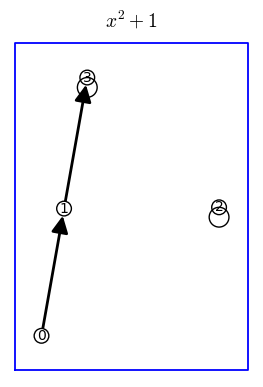

In [49]:
lst = []
for prime in FF.places_finite(1):
    lst.append(prime.local_uniformizer())
DS1 = DynamicalSystem([x^2 + y^2   ,y^2]) 
plot(rational_preperiodic_graph(DS1,lst,1),figsize=6,vertex_color = "white",title = "$x^2 + 1$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

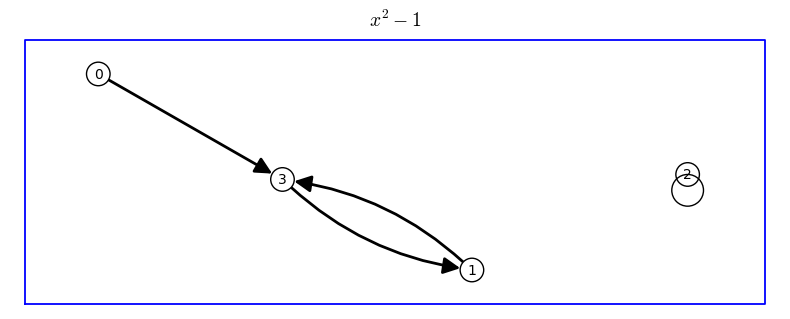

In [50]:
DS2 = DynamicalSystem([x^2 - y^2   ,y^2]) 
plot(rational_preperiodic_graph(DS2,lst,1),figsize=8,vertex_color = "white",title = "$x^2 - 1$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

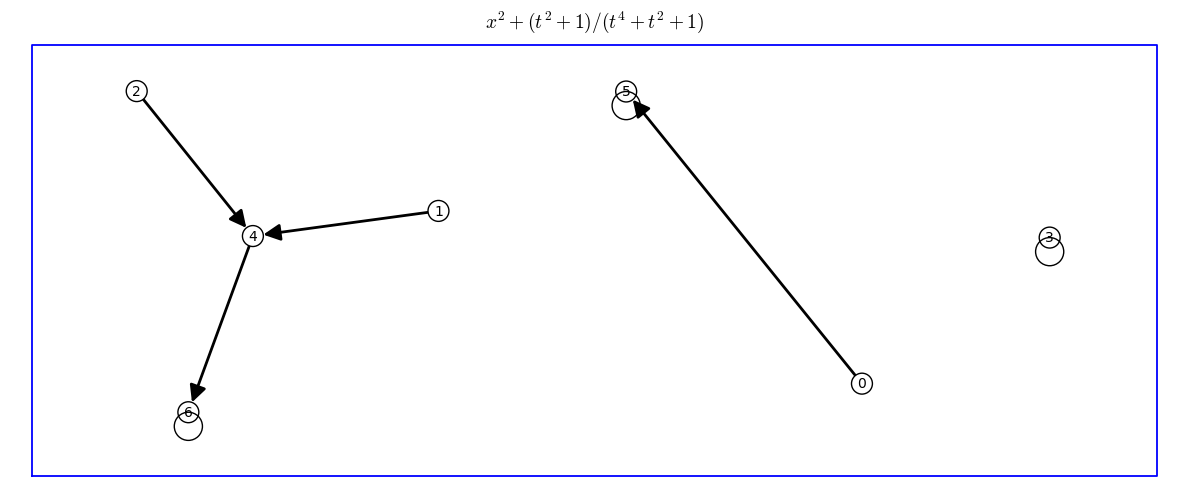

In [51]:
DS3 = DynamicalSystem([x^2 + (y^2)*((t^2 + 1)/(t^4 + t^2 +1))  ,y^2]) 
plot(rational_preperiodic_graph(DS3,lst,1),figsize=12,vertex_color = "white",title = "$x^2 + (t^2 + 1) / (t^4 + t^2 +1)$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

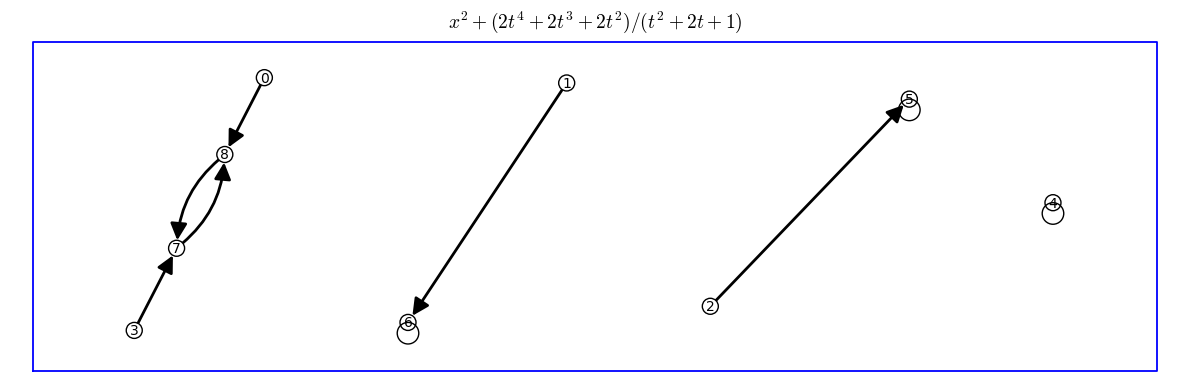

In [52]:
DS4 = DynamicalSystem([x^2 + (y^2)*((2*t^4 + 2*t^3 + 2*t^2)/(t^2 + 2*t + 1))  ,y^2]) 
plot(rational_preperiodic_graph(DS4,lst,1),figsize=12,vertex_color = "white",title = "$x^2 + (2t^4 + 2t^3 + 2t^2)/(t^2 + 2t + 1)$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

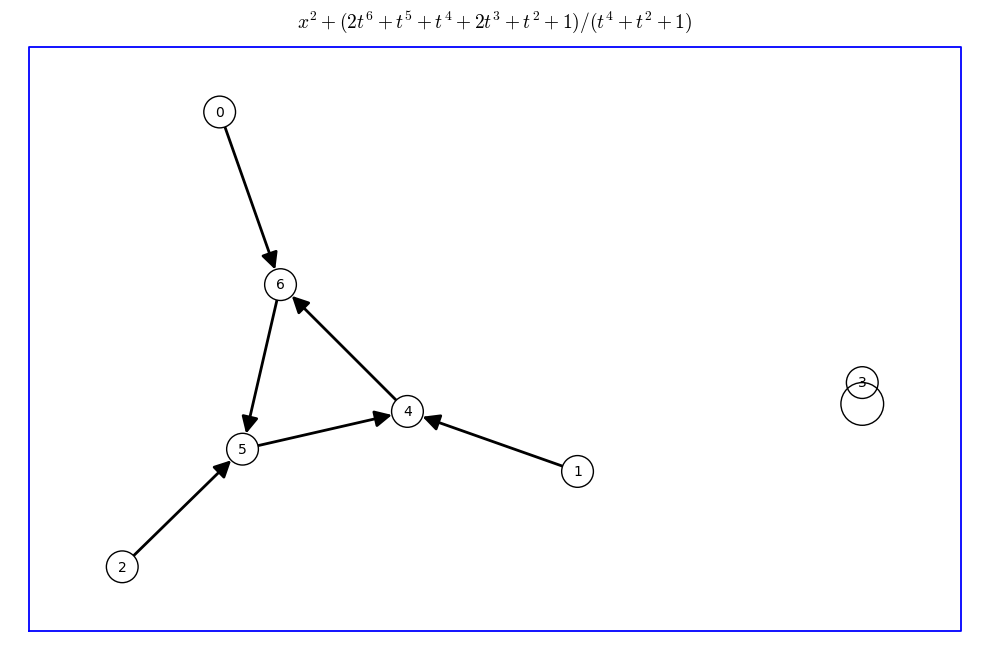

In [53]:
DS5 = DynamicalSystem([x^2 + (y^2)*((2*t^6 + t^5 + t^4 + 2*t^3 + t^2 + 1)/(t^4 + t^2 + 1))  ,y^2]) 
plot(rational_preperiodic_graph(DS5,lst,1),figsize=10,vertex_color = "white",title = "$x^2 + (2t^6 + t^5 + t^4 + 2t^3 + t^2 + 1)/(t^4 + t^2 + 1)$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

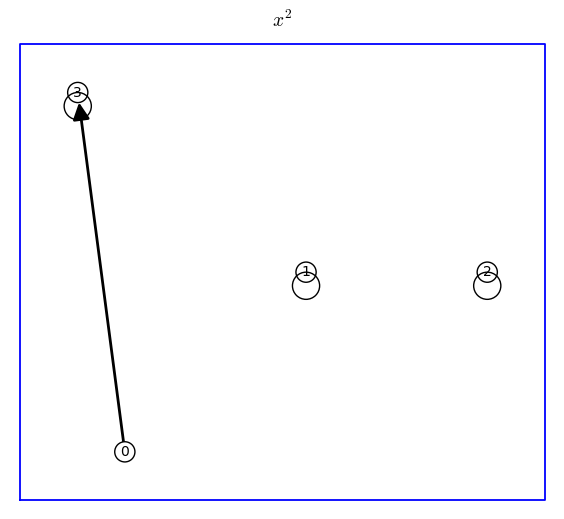

In [54]:
DS6 = DynamicalSystem([x^2 ,y^2]) 
plot(rational_preperiodic_graph(DS6,lst,1),figsize=8,vertex_color = "white",title = "$x^2$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

In [55]:
func_str = str((2*t^6 + t^5 + t^4 + 2*t^3 + t^2 + 1)/(t^4 + t^2 + 1)) 
func_eval = sage_eval(func_str,locals={'x':x , 't':t}) ;func_eval

(2*t^6 + t^5 + t^4 + 2*t^3 + t^2 + 1)/(t^4 + t^2 + 1)

In [56]:
def rational_preperiodic_graph(self,primes,e):
    DS = copy(self)
    periods = all_possible_global_periods(DS,primes,e)
    periodic_points1 = all_periodic_points(DS,periods)
    preperiodic_points = all_preperiodic_points(DS,periodic_points1)
    g1 = DS._preperiodic_points_to_cyclegraph(preperiodic_points)
    g2 = g1.canonical_label()
    g3 = g2.copy(immutable=True)
    return g3

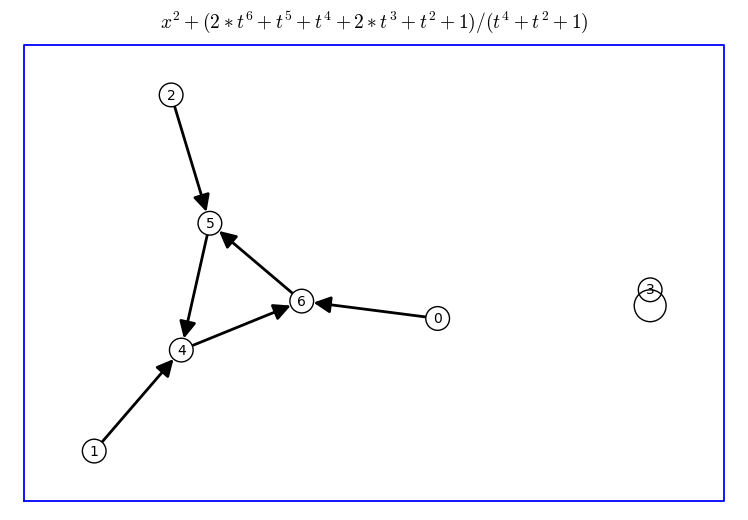

In [57]:
DS7 = DynamicalSystem([x^2+(2*t^6+t^5+t^4+2*t^3+t^2+1)/(t^4+t^2+1)*y^2 ,y^2]) 
plot(rational_preperiodic_graph(DS7,lst,1),figsize=8,vertex_color = "white",title = "$x^2 + (2*t^6+t^5+t^4+2*t^3+t^2+1)/(t^4+t^2+1)$",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True)

In [21]:
def generate_list(filename):
    lst_graphs = []
    with open(filename) as file_in:
        for func_str in file_in:
            # converte the string to a mathematical expression
            func_eval = sage_eval(func_str,locals={'x':x , 't':t})
            DS = DynamicalSystem_projective([x^2 + func_eval*y^2 , y^2 ])
            # add to the list the graph of the given dynamical system
            lst_graphs.append(rational_preperiodic_graph(DS,lst,1))
    file_in.close()
    return lst_graphs

In [63]:
%%time
graphs = generate_list("haha.txt")

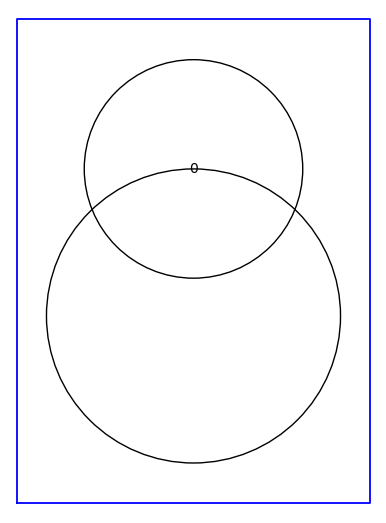

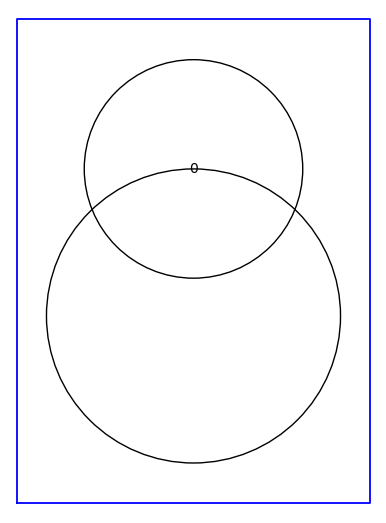

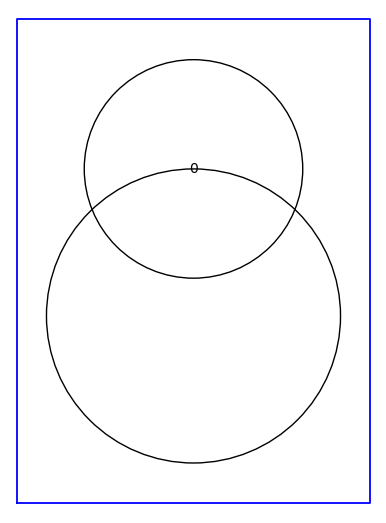

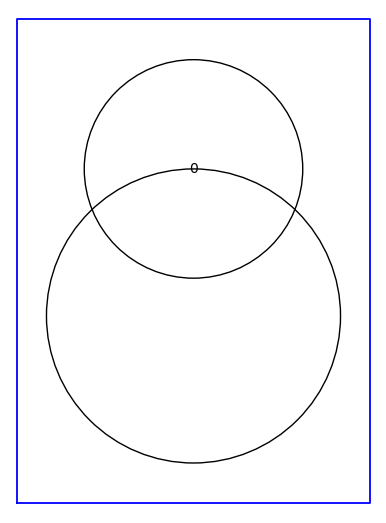

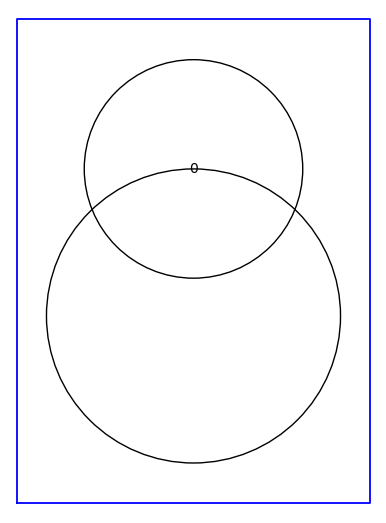

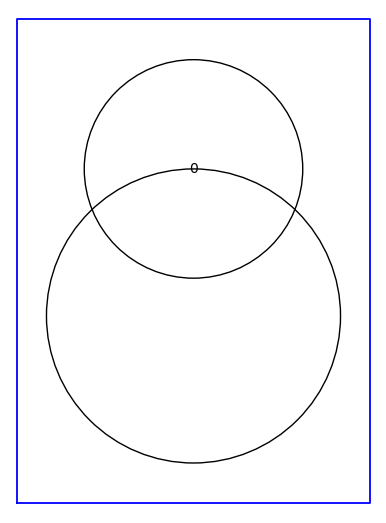

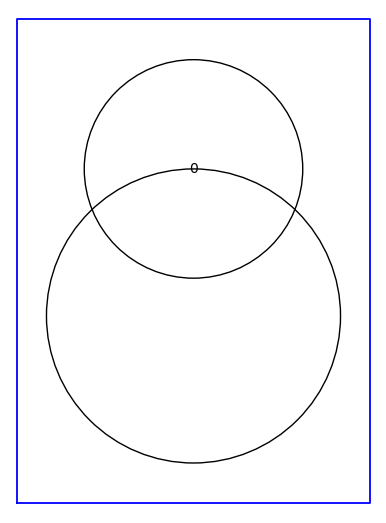

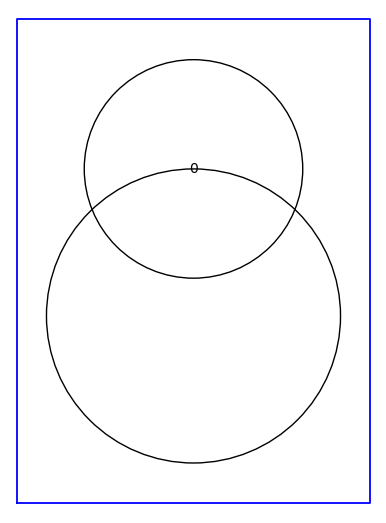

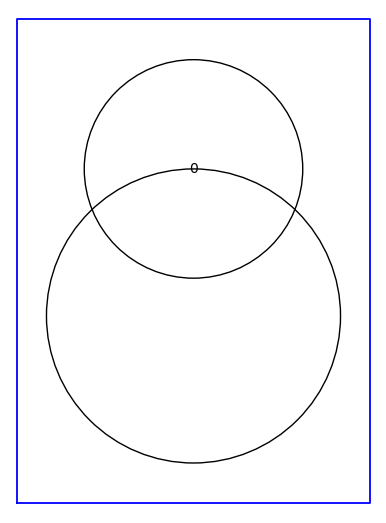

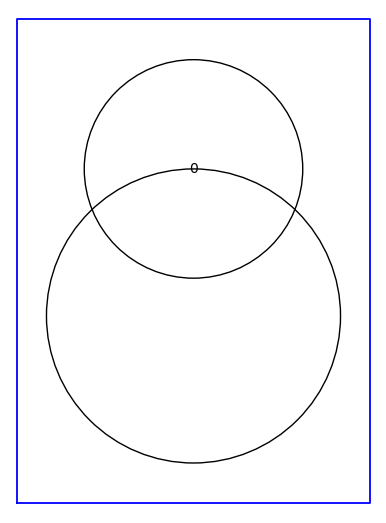

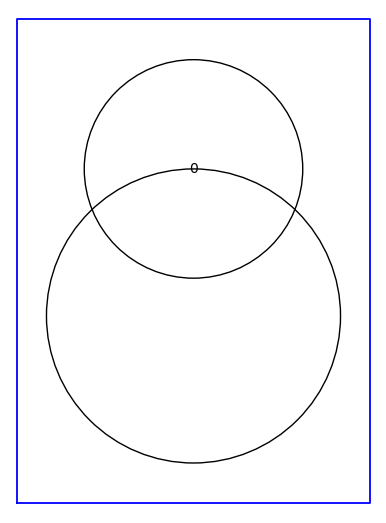

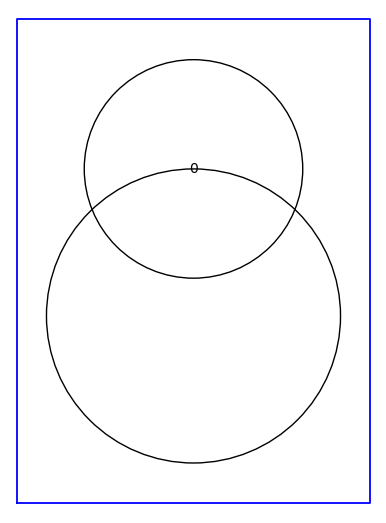

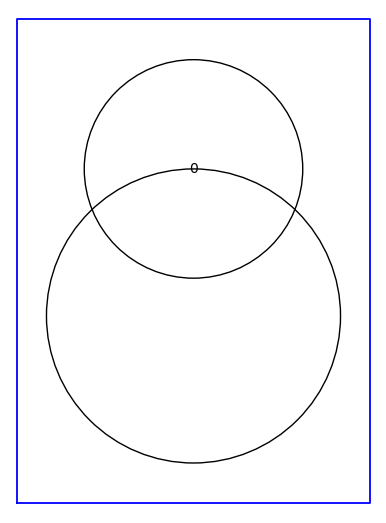

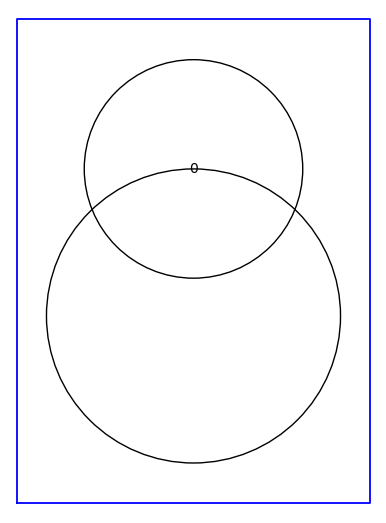

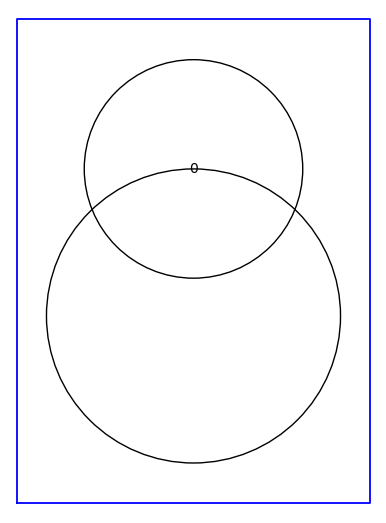

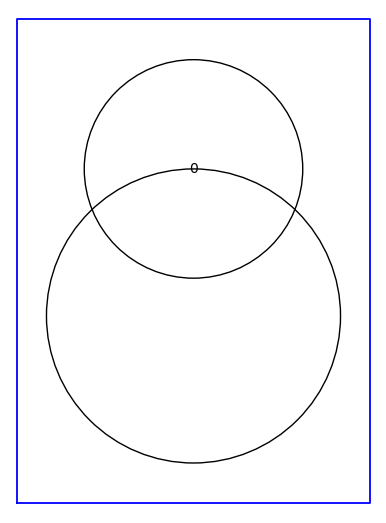

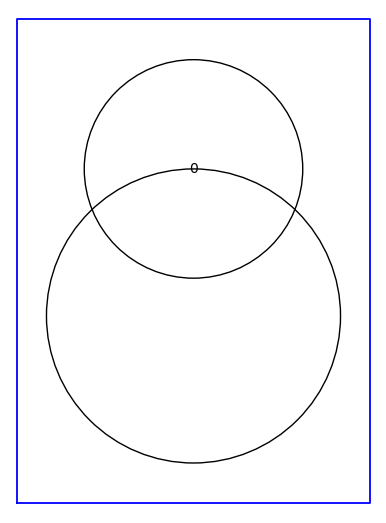

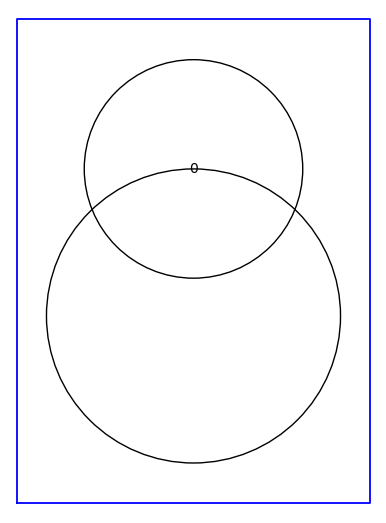

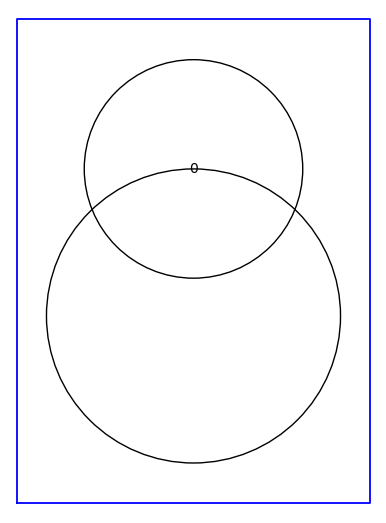

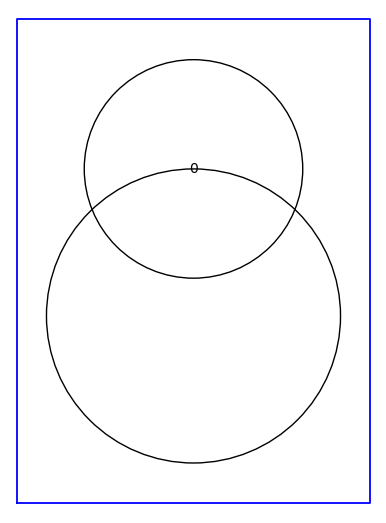

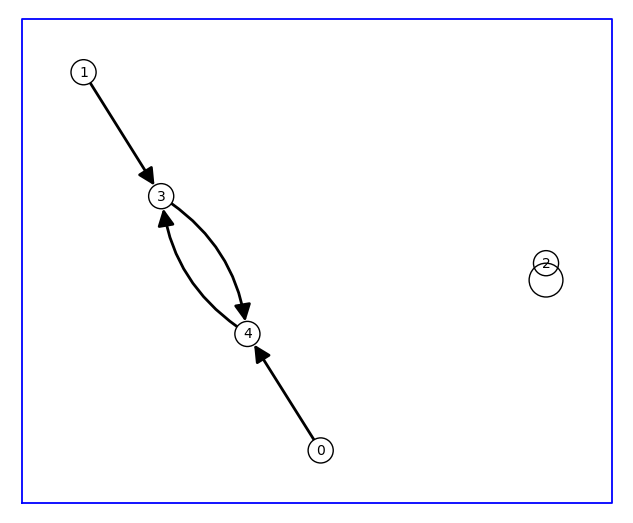

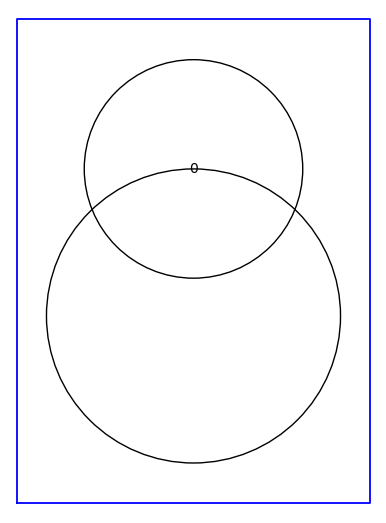

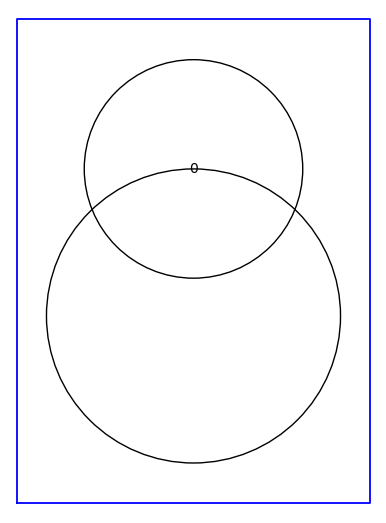

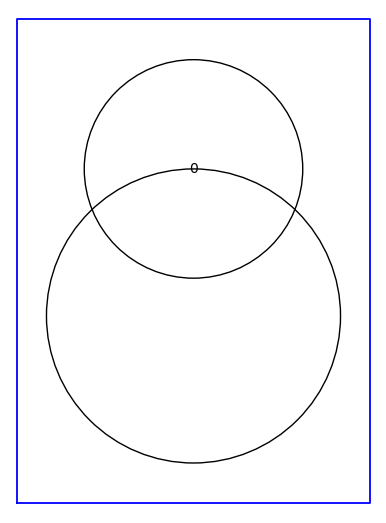

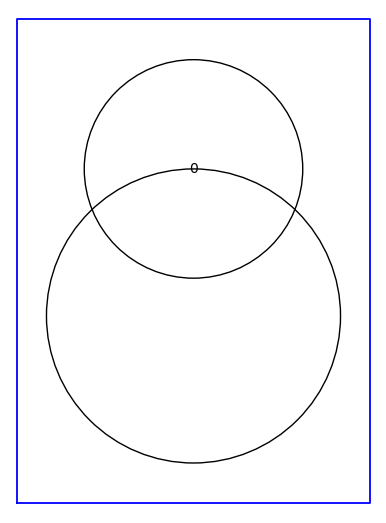

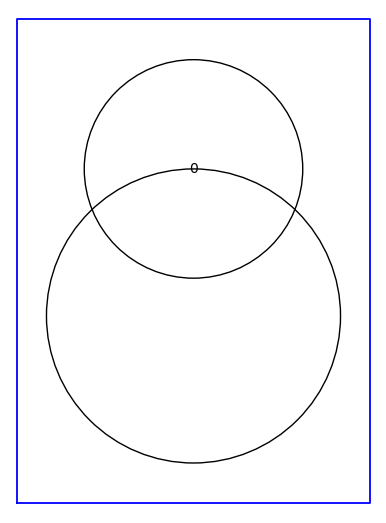

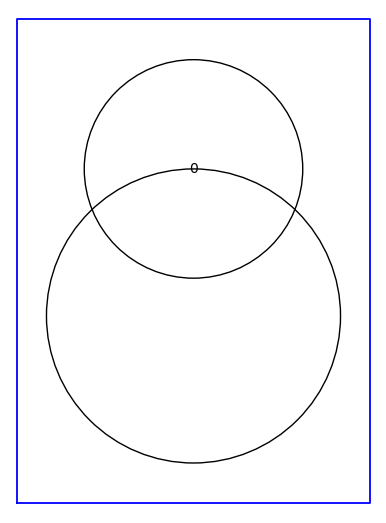

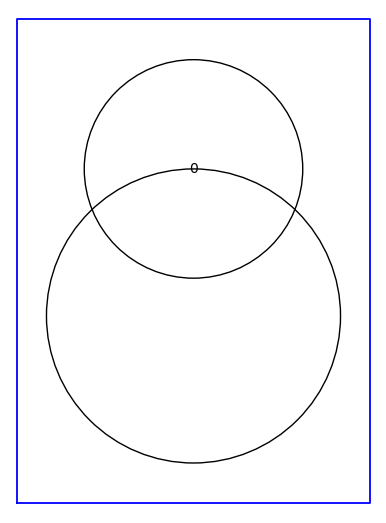

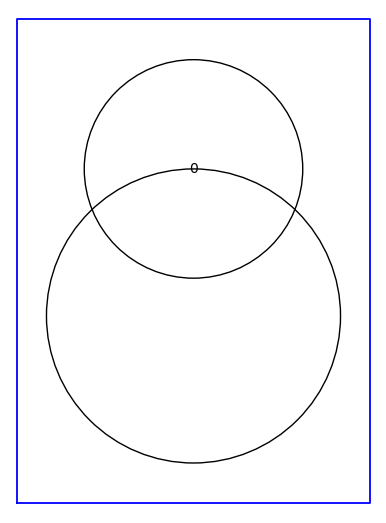

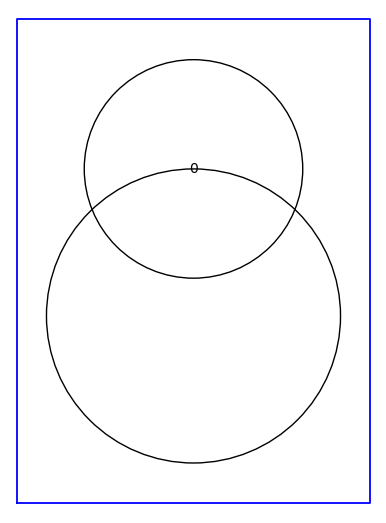

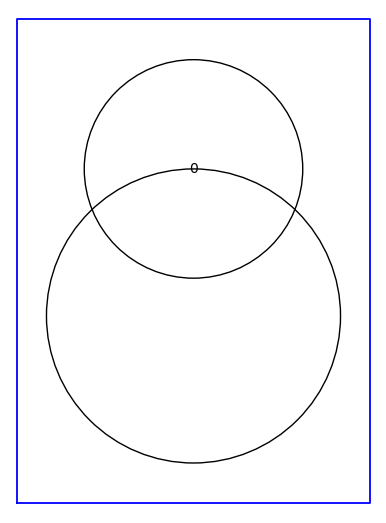

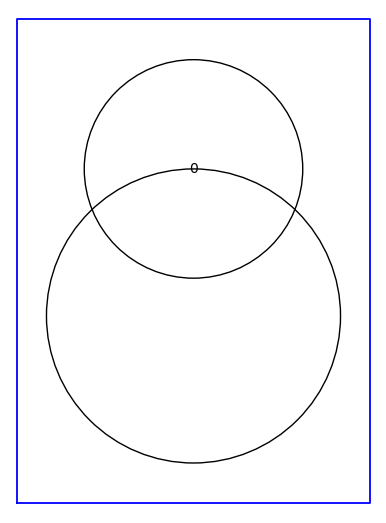

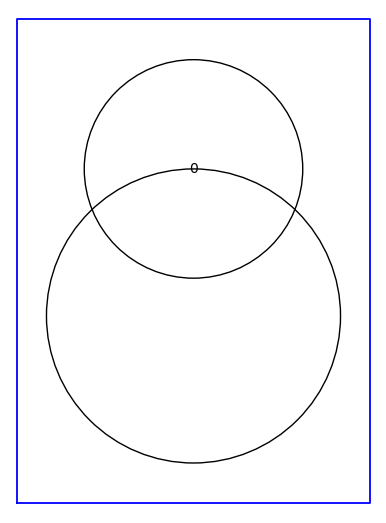

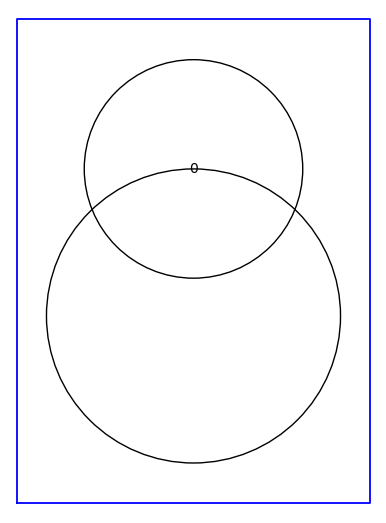

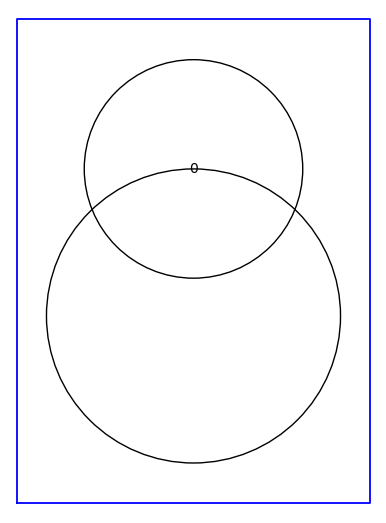

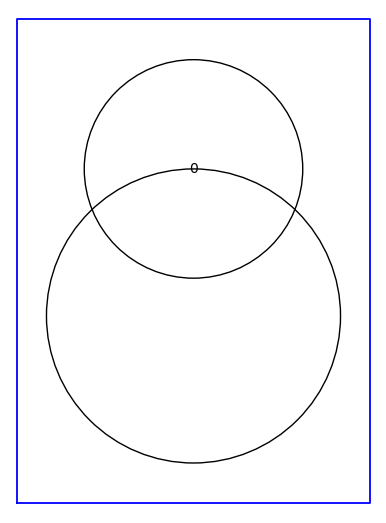

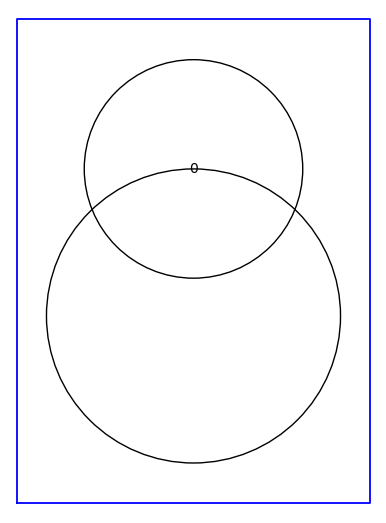

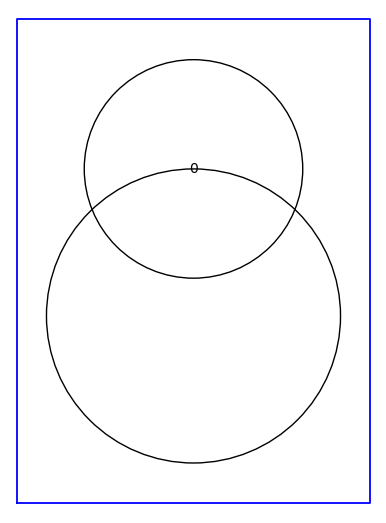

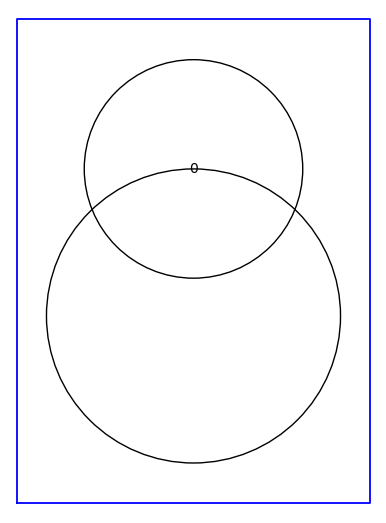

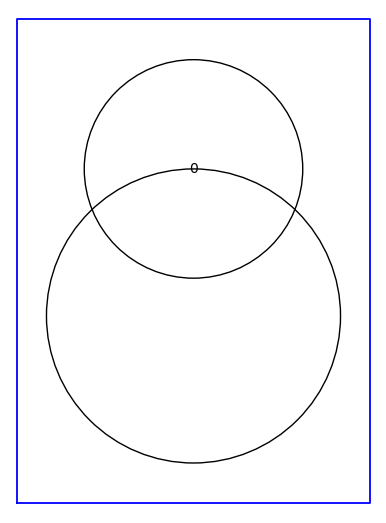

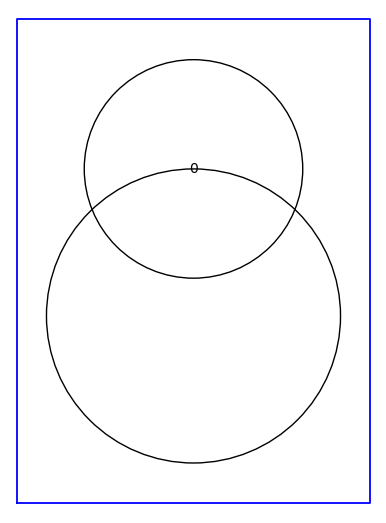

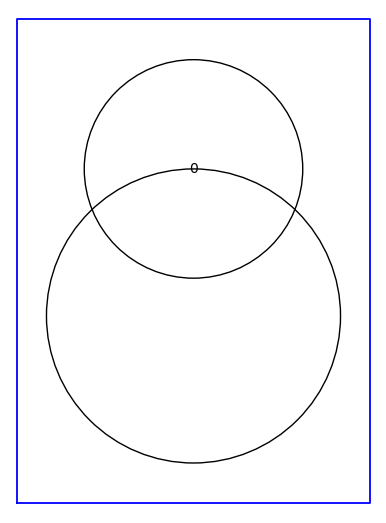

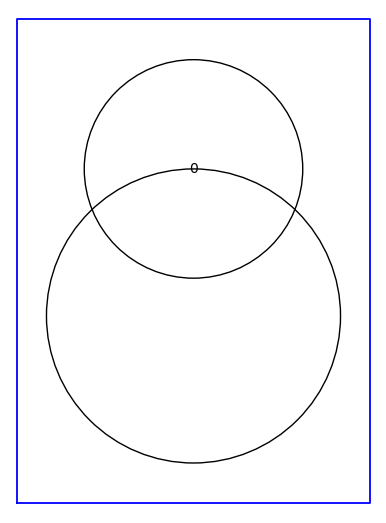

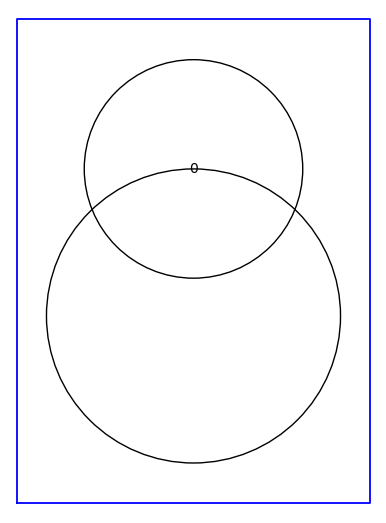

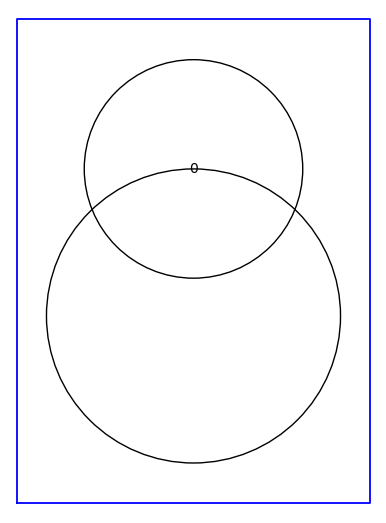

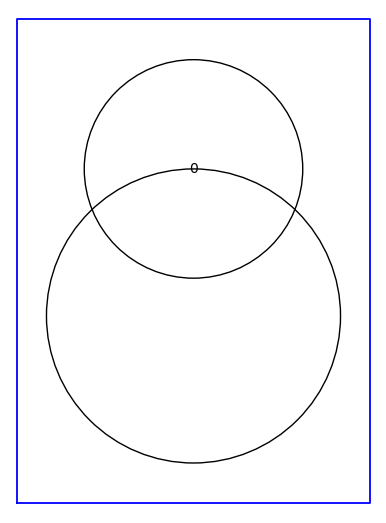

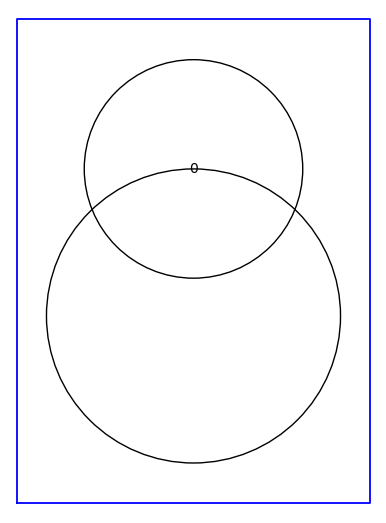

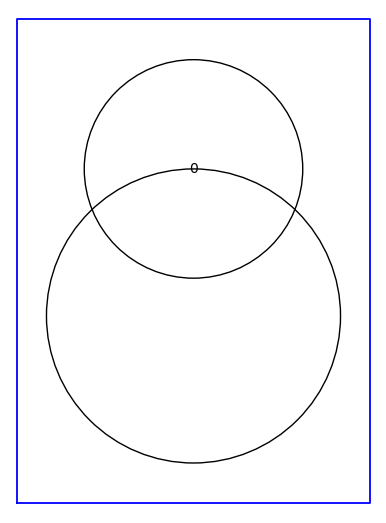

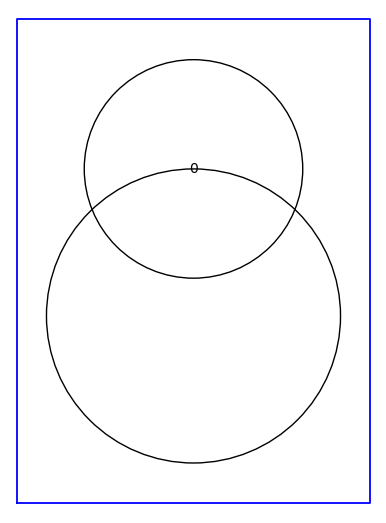

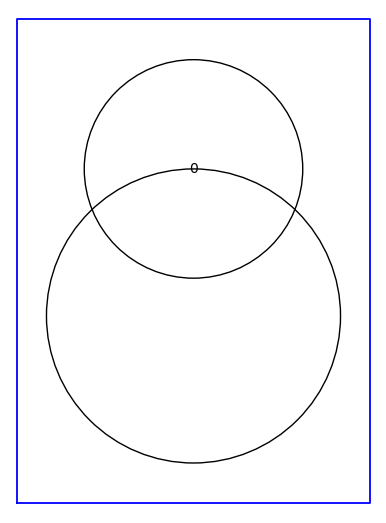

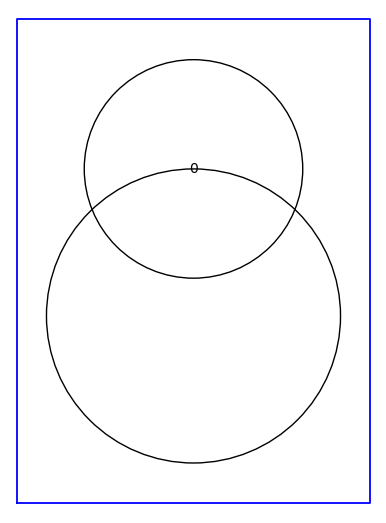

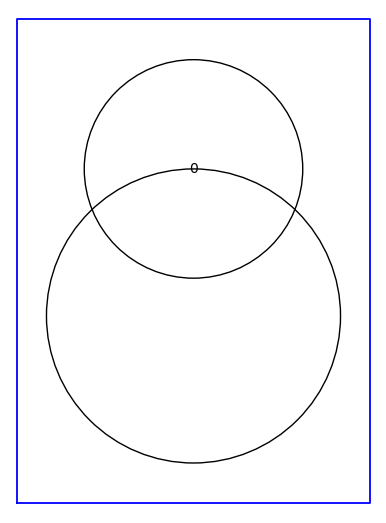

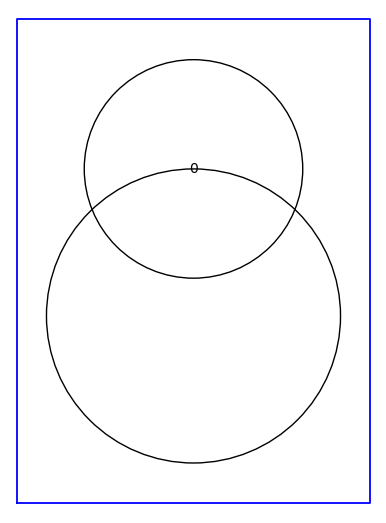

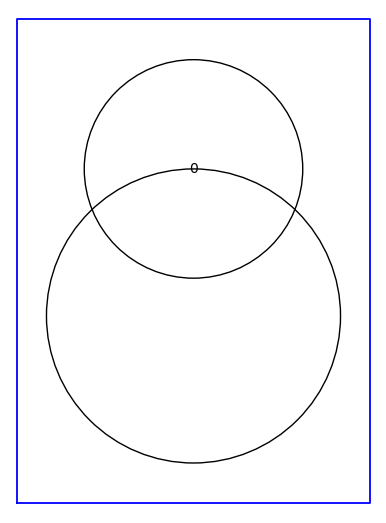

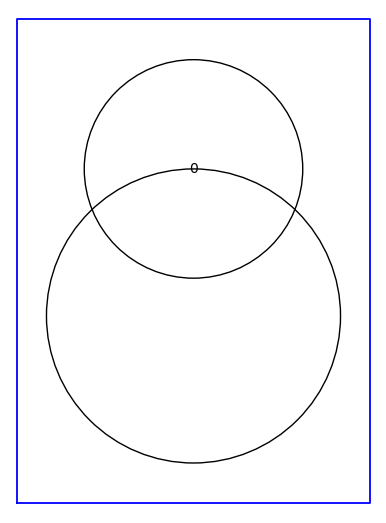

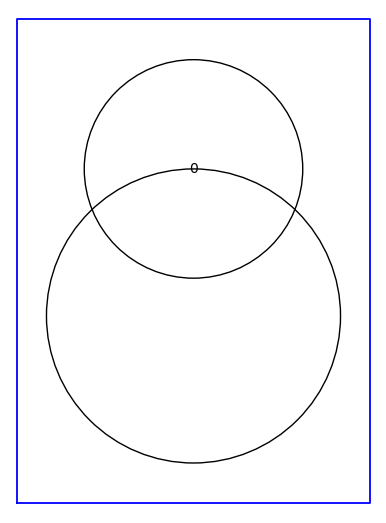

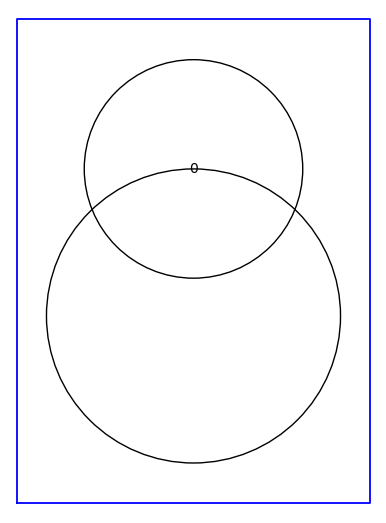

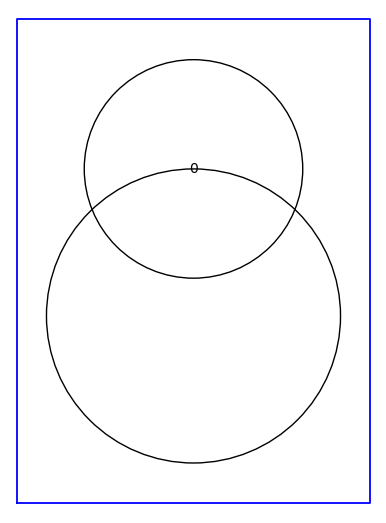

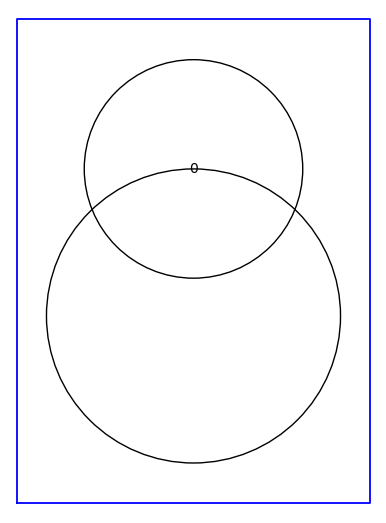

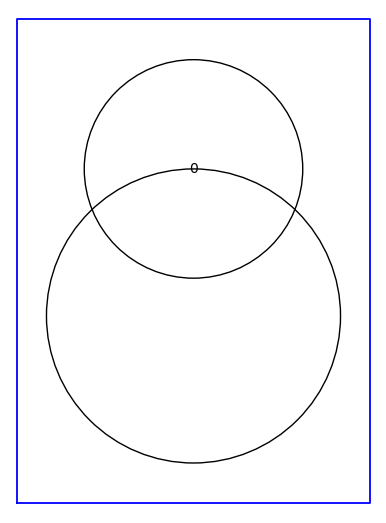

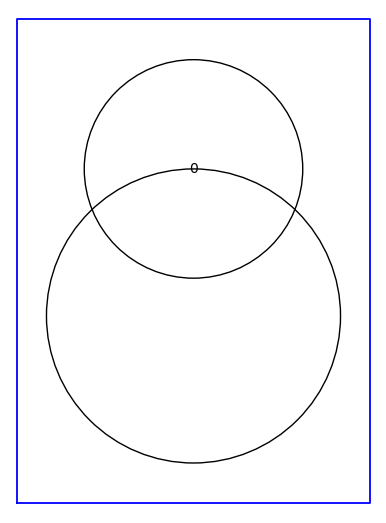

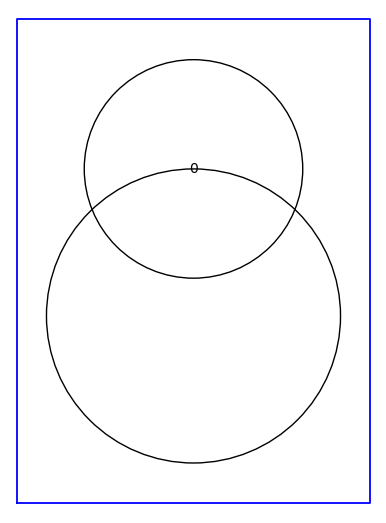

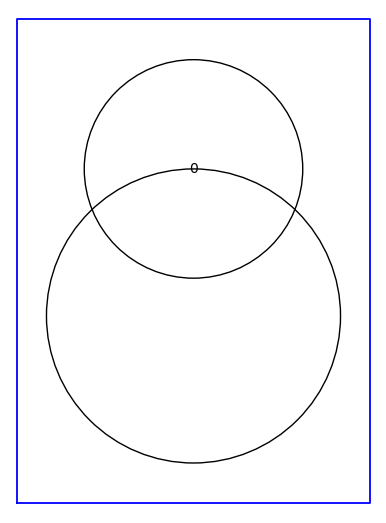

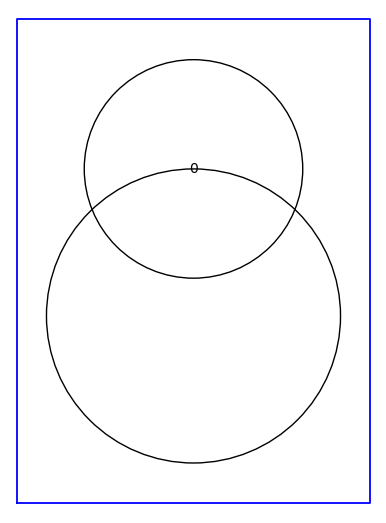

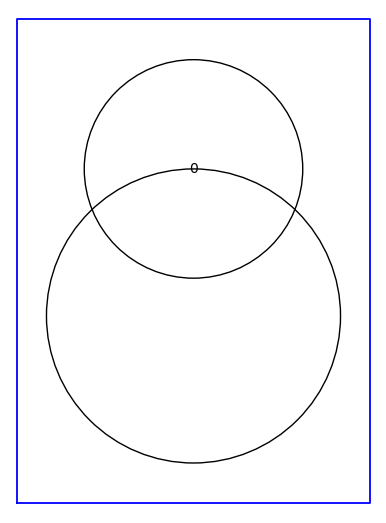

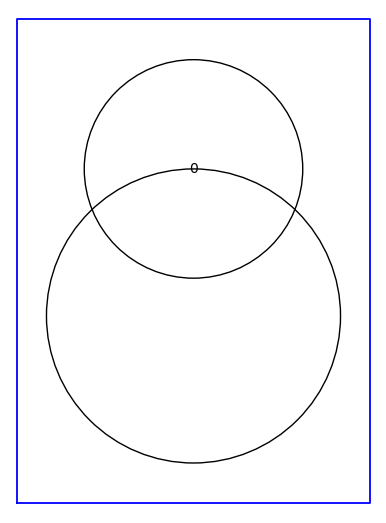

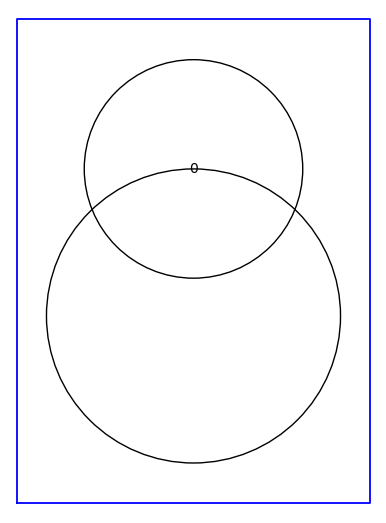

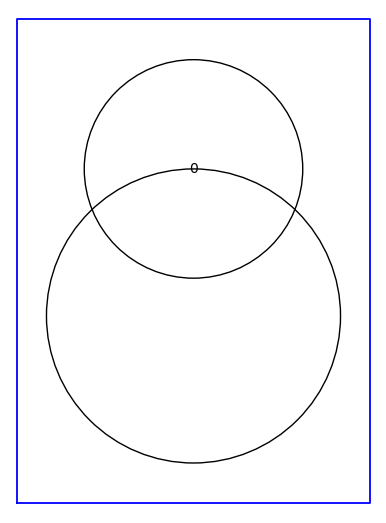

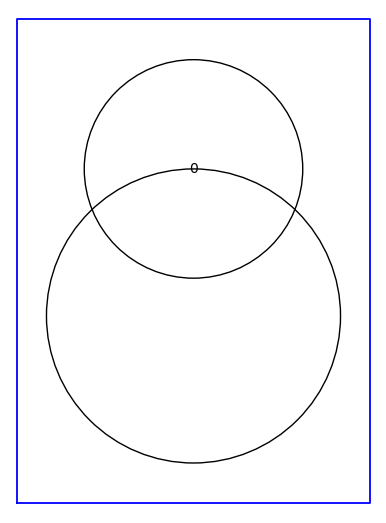

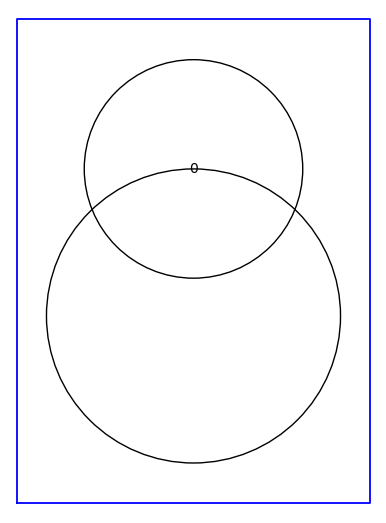

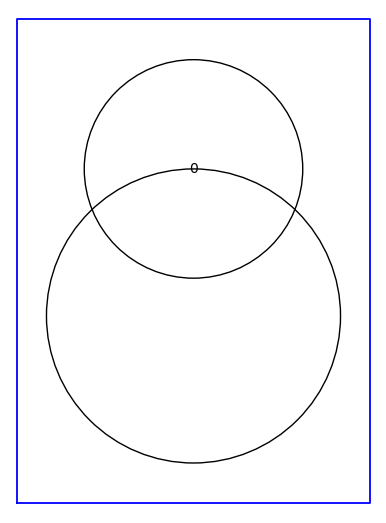

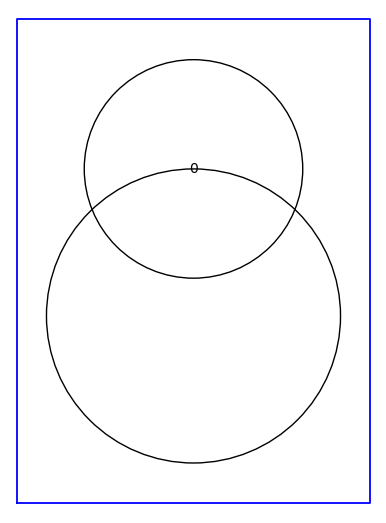

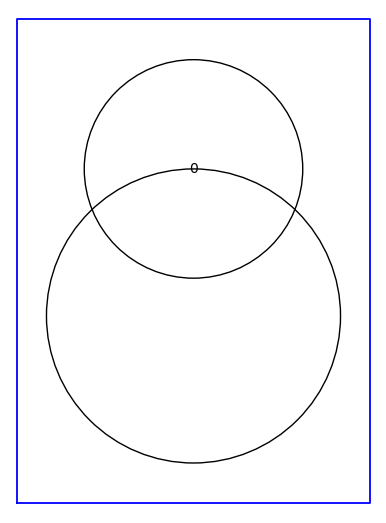

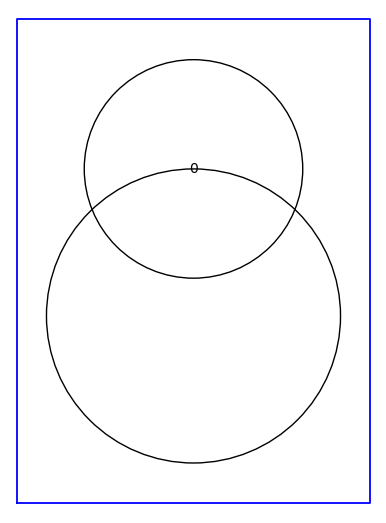

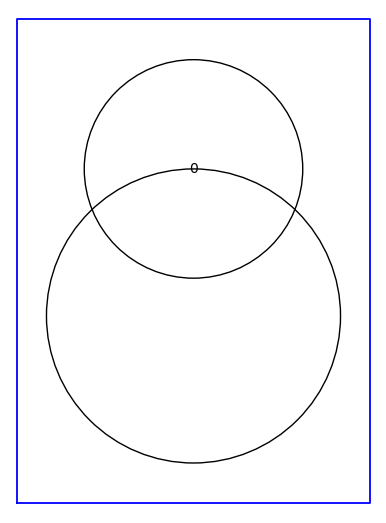

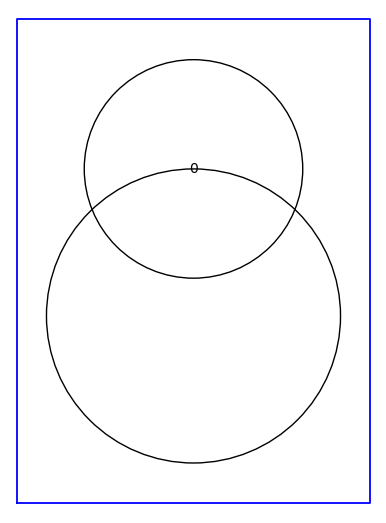

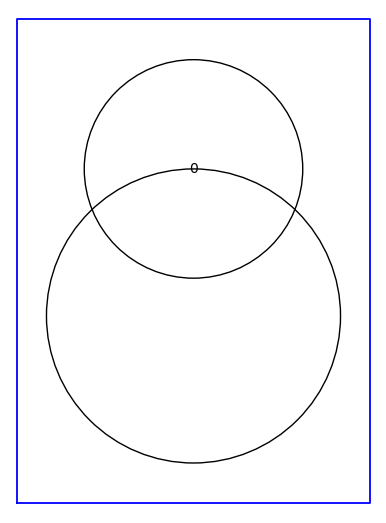

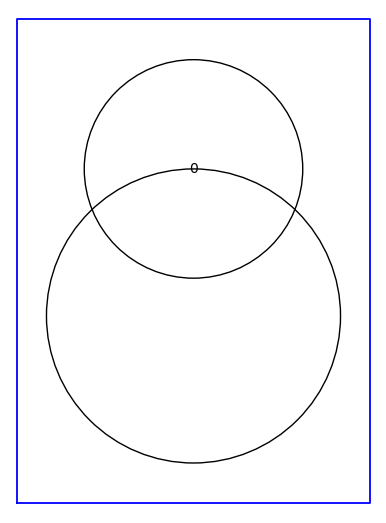

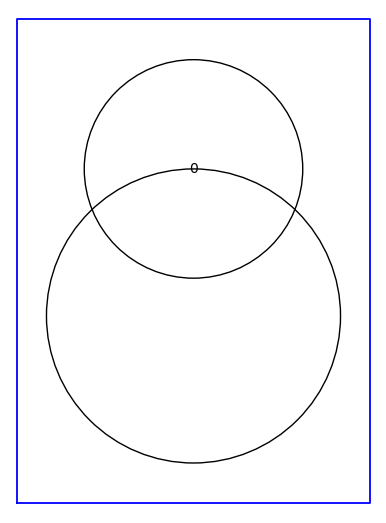

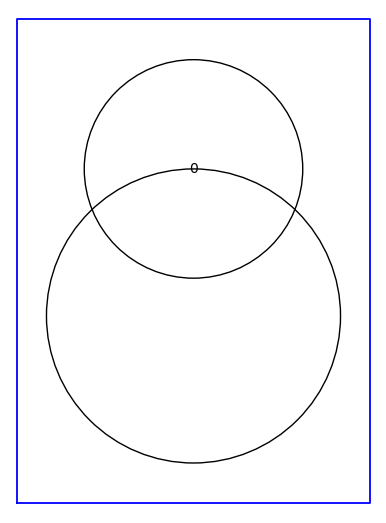

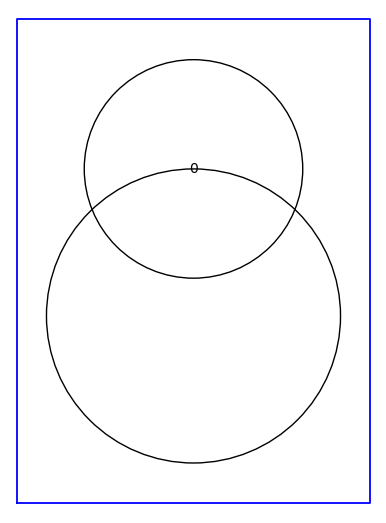

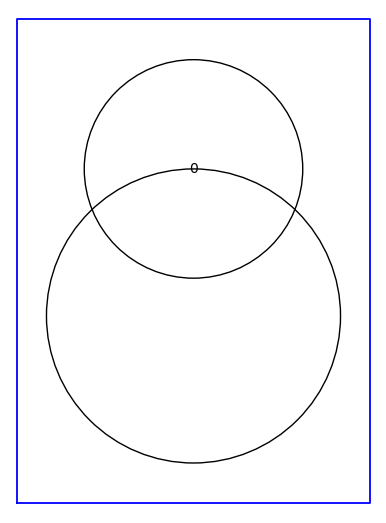

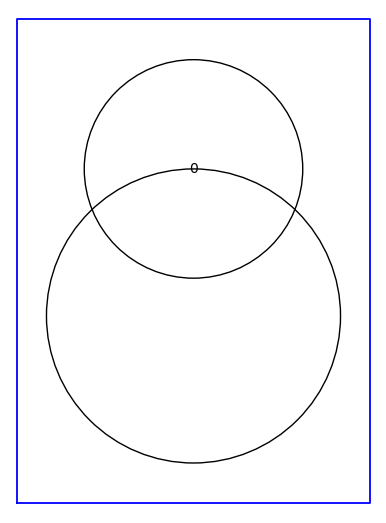

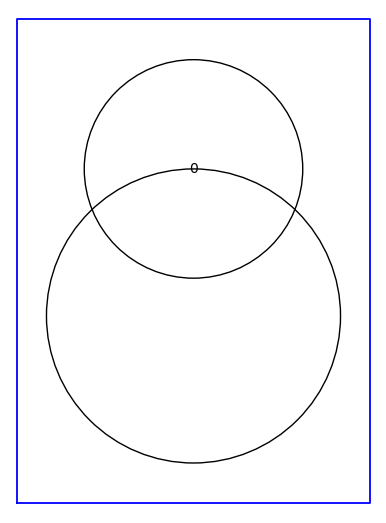

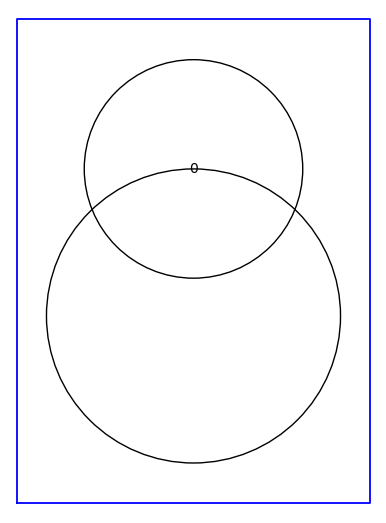

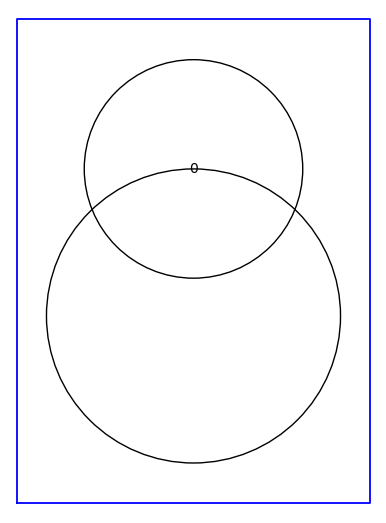

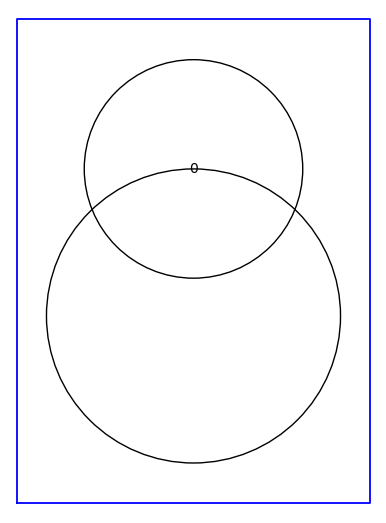

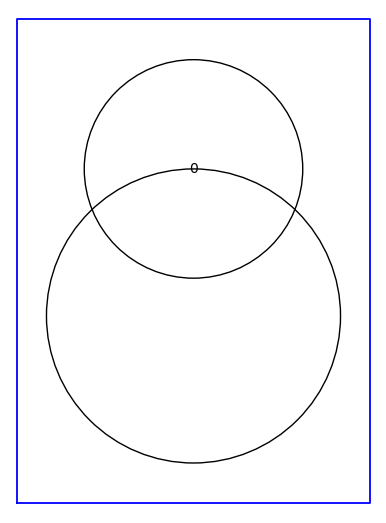

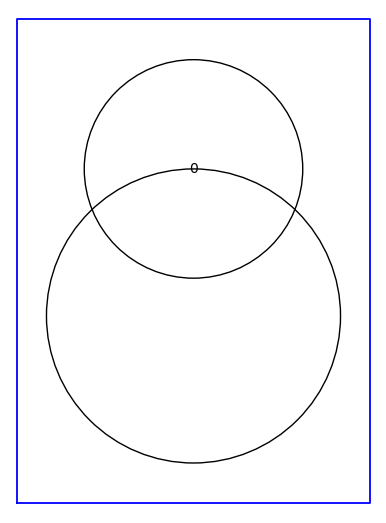

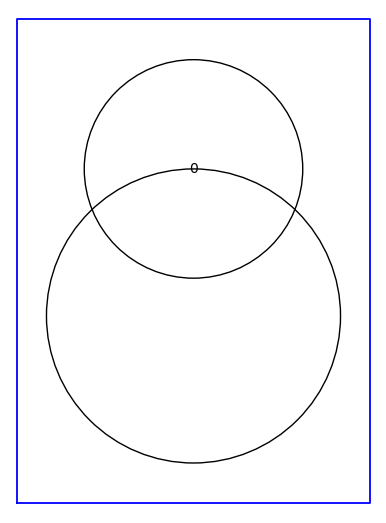

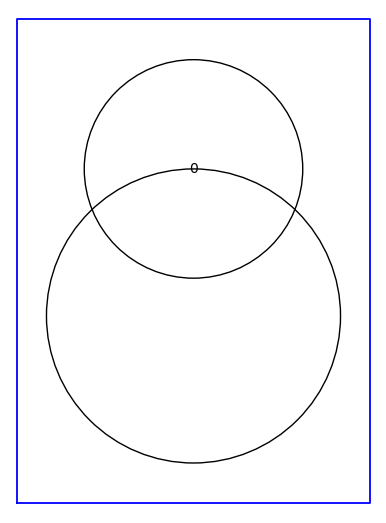

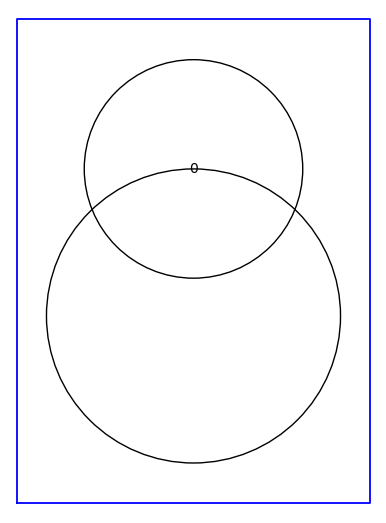

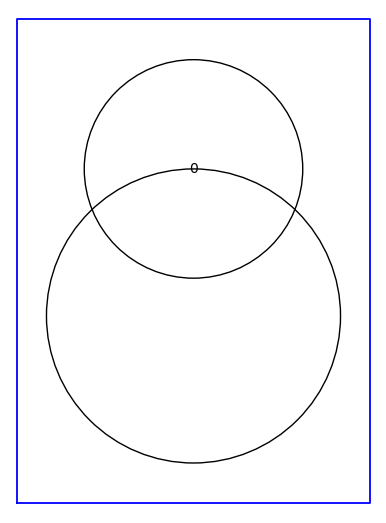

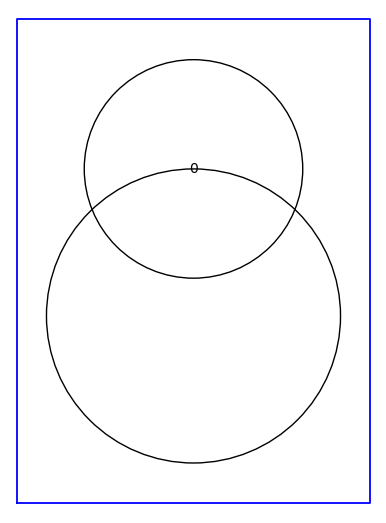

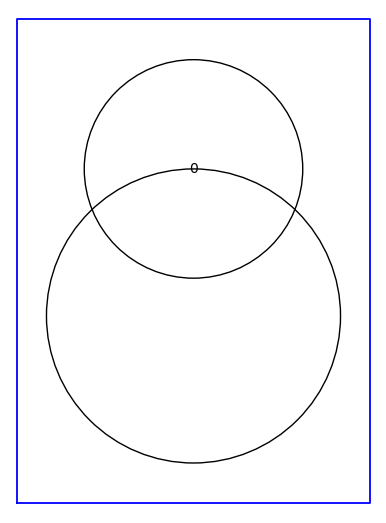

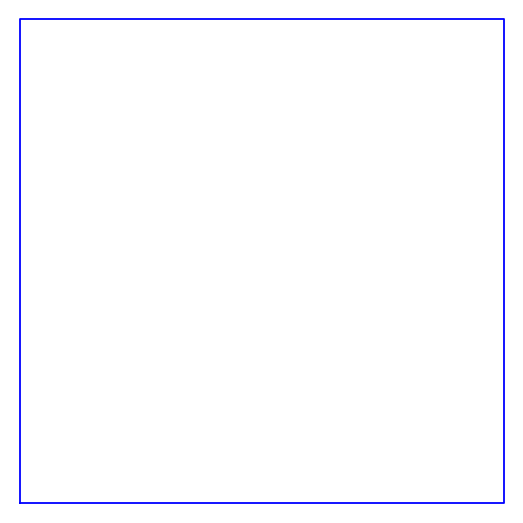

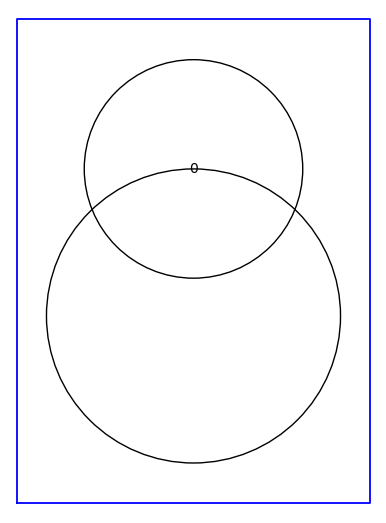

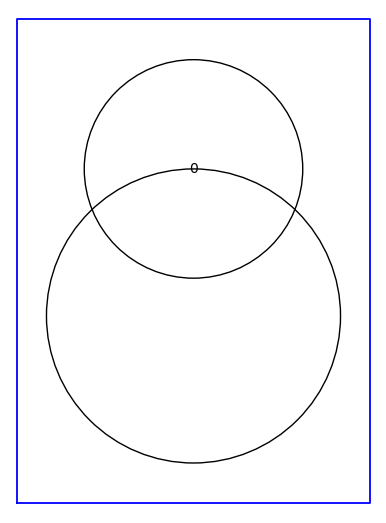

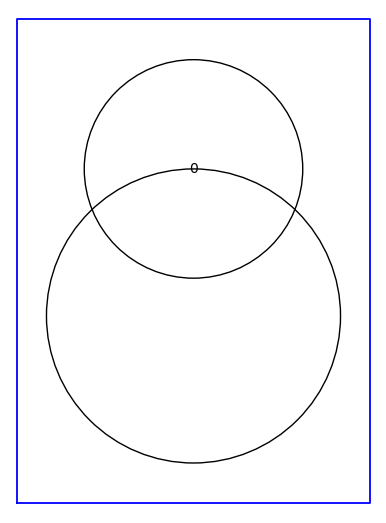

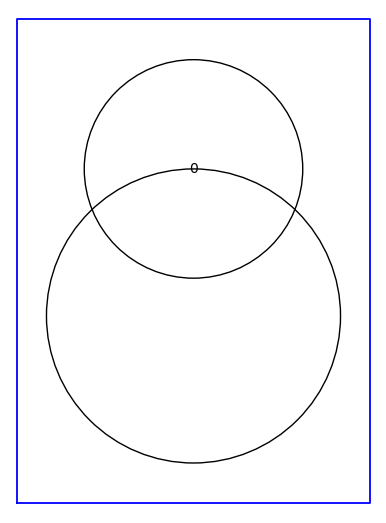

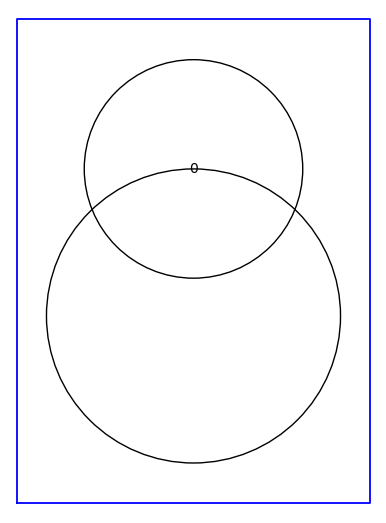

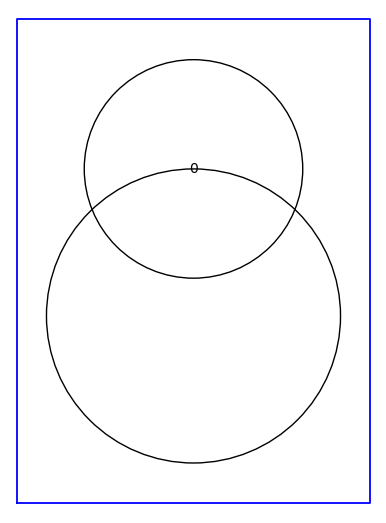

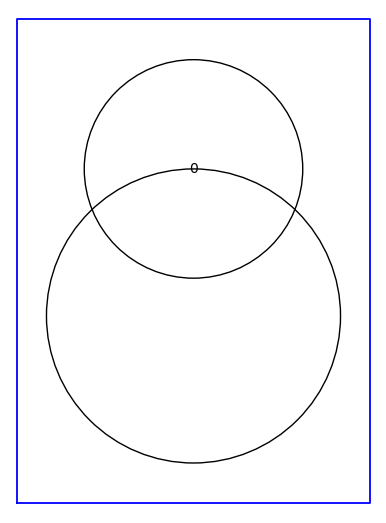

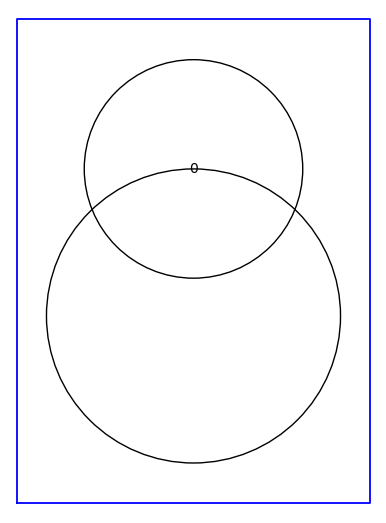

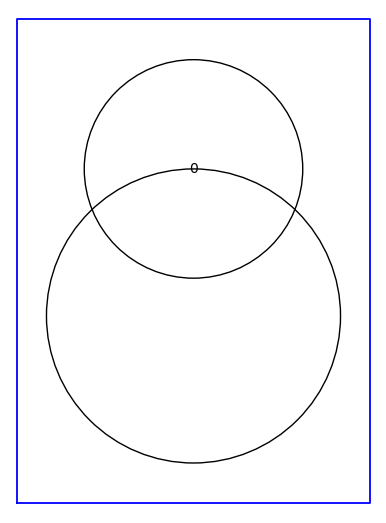

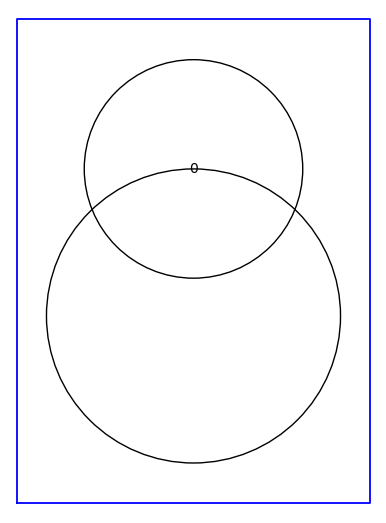

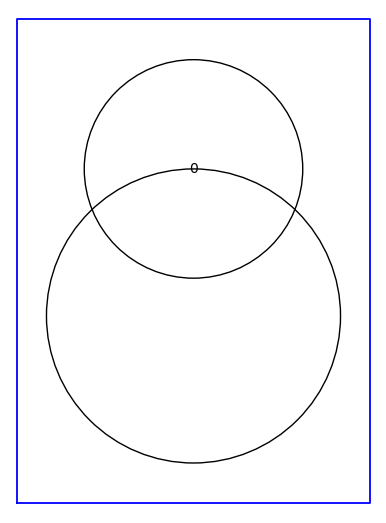

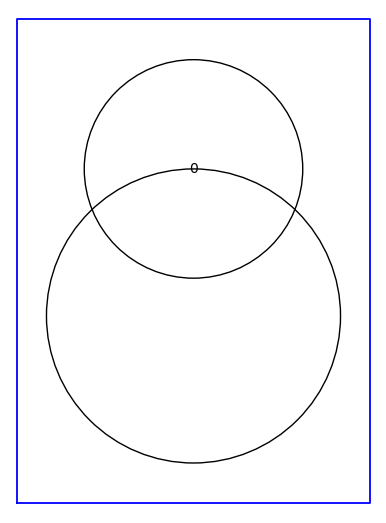

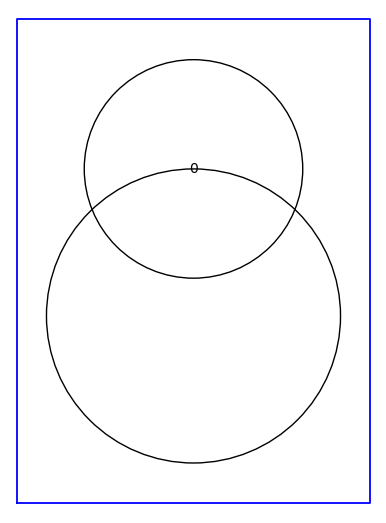

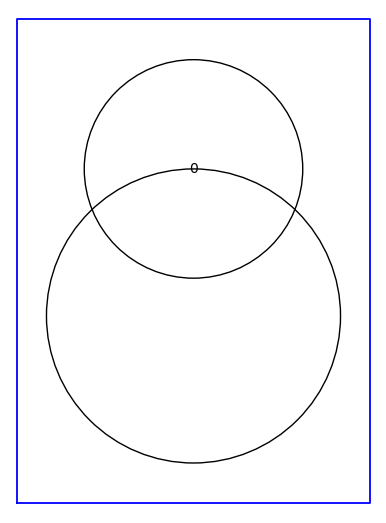

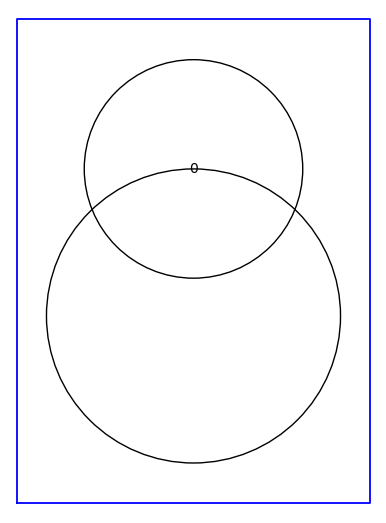

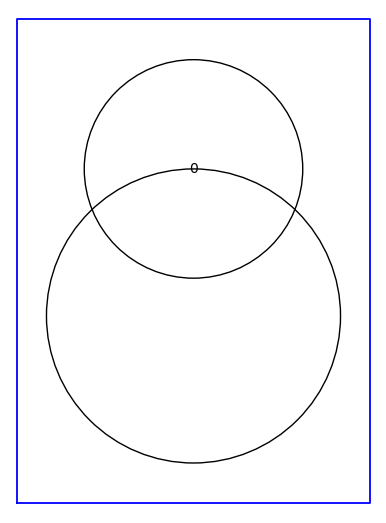

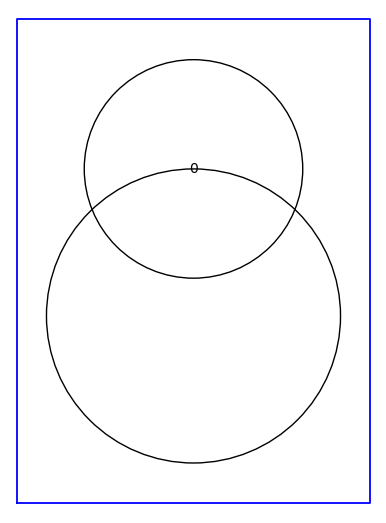

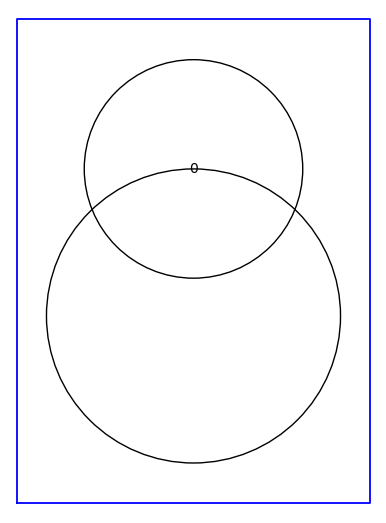

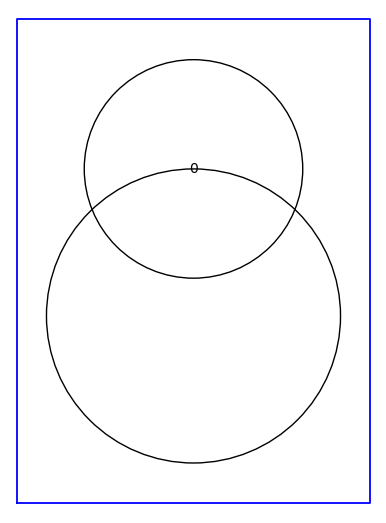

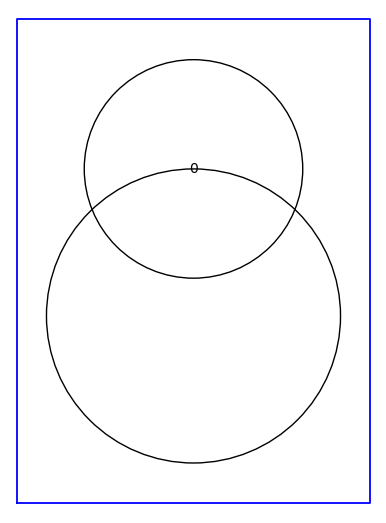

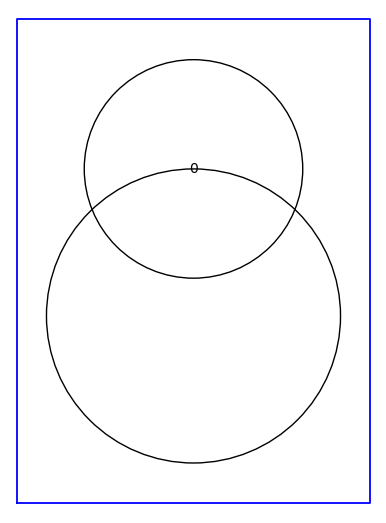

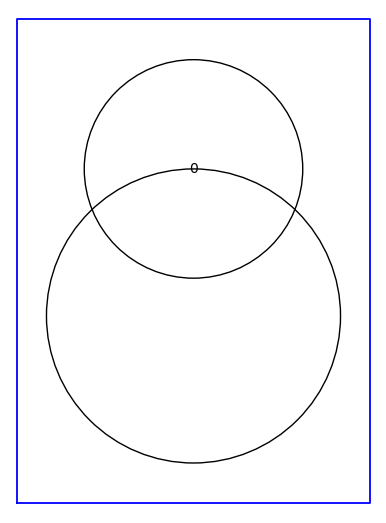

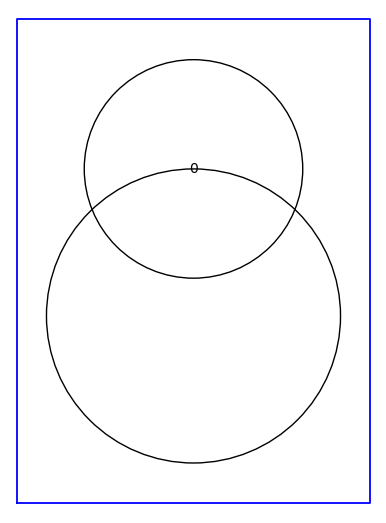

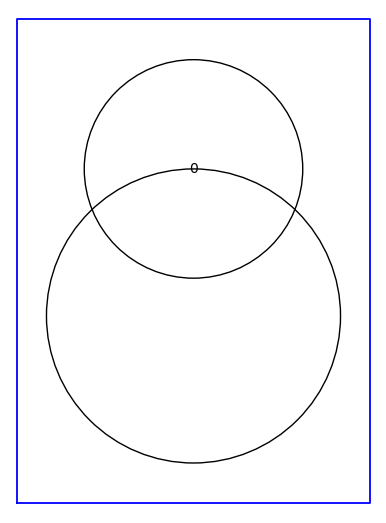

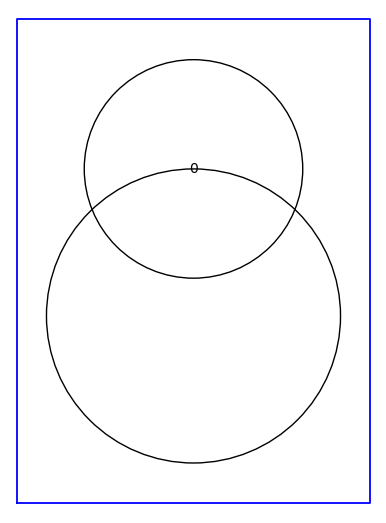

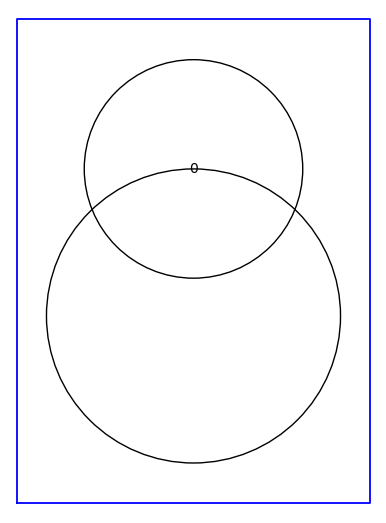

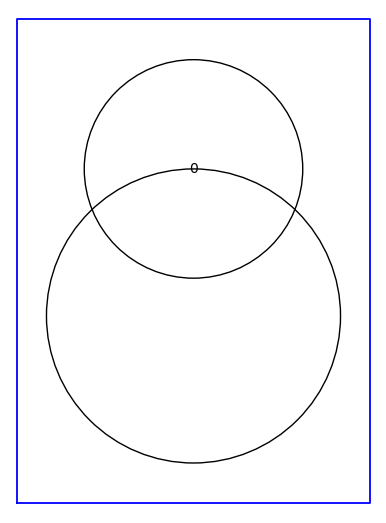

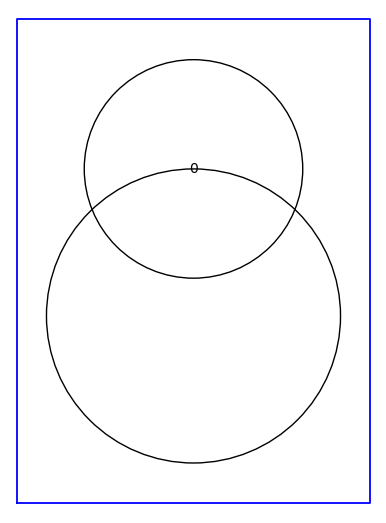

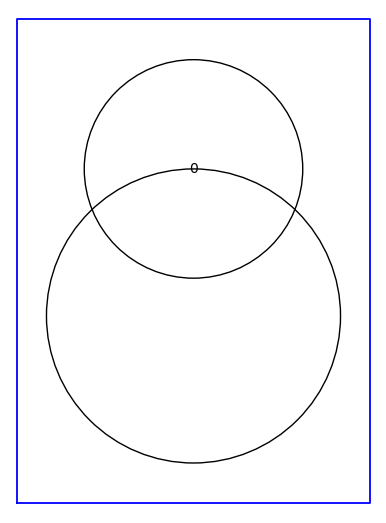

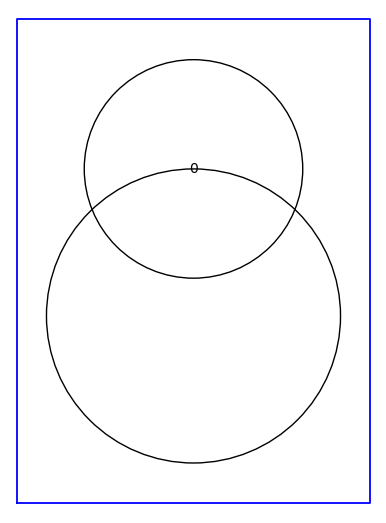

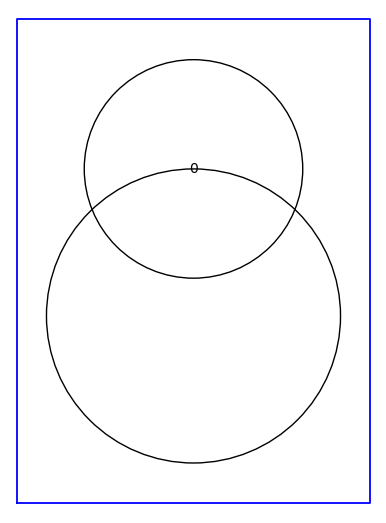

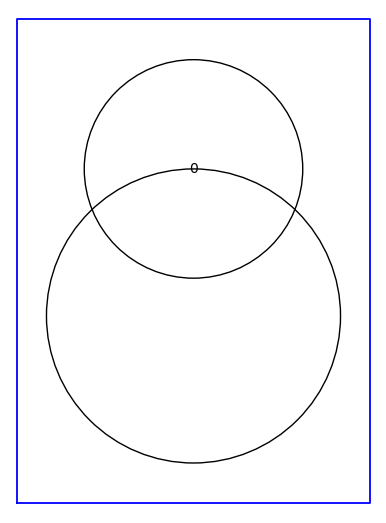

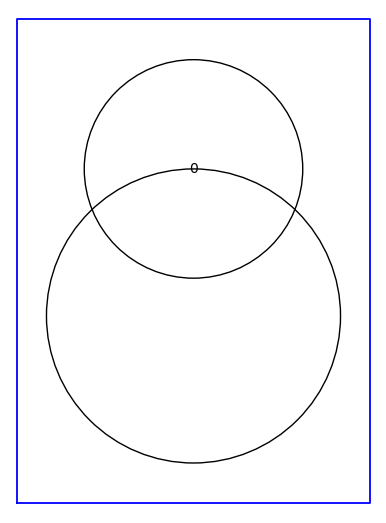

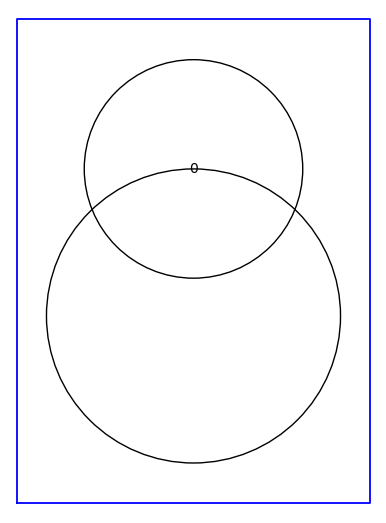

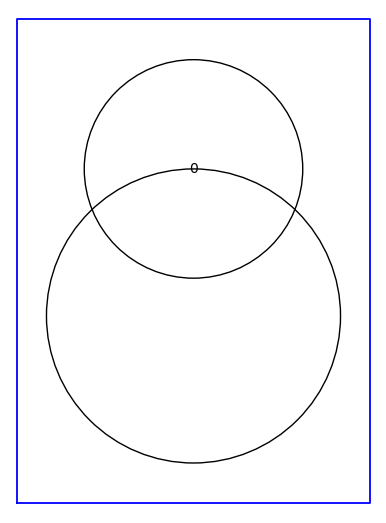

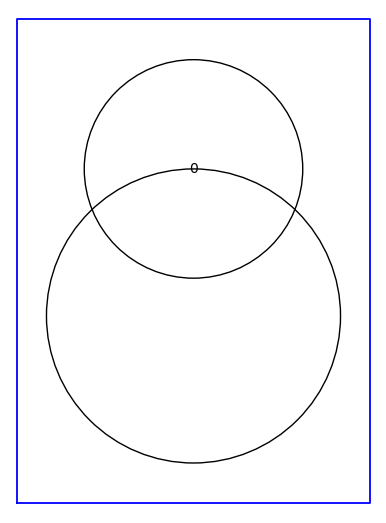

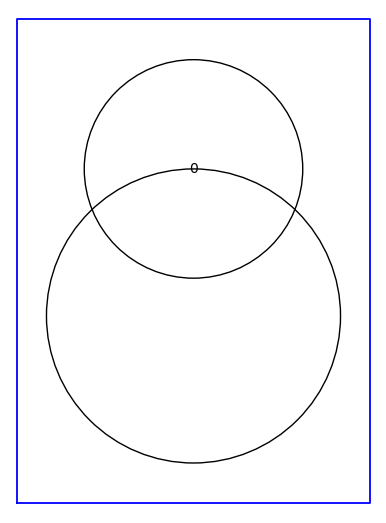

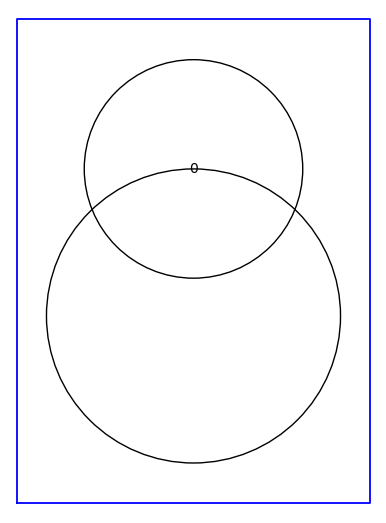

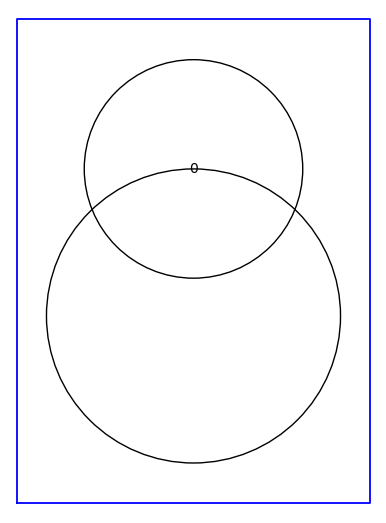

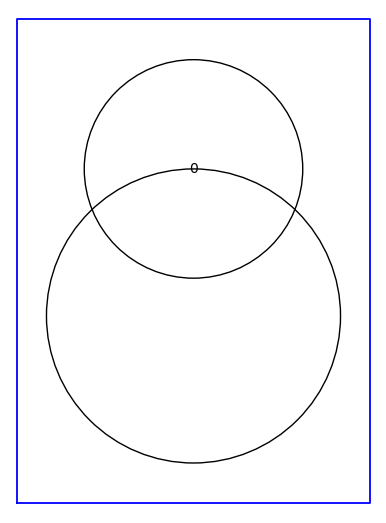

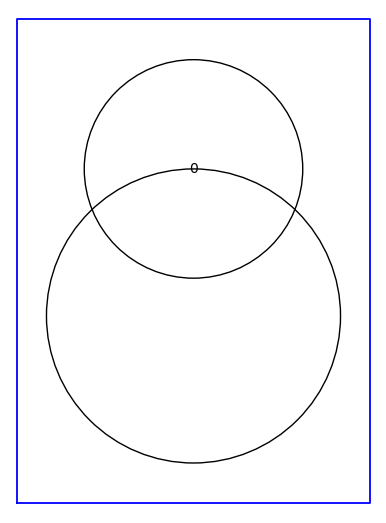

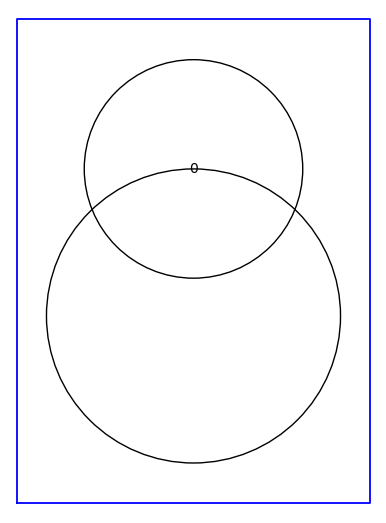

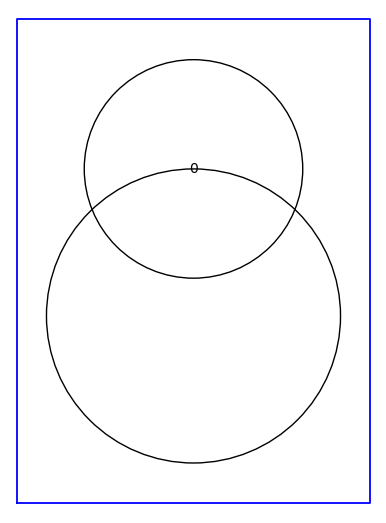

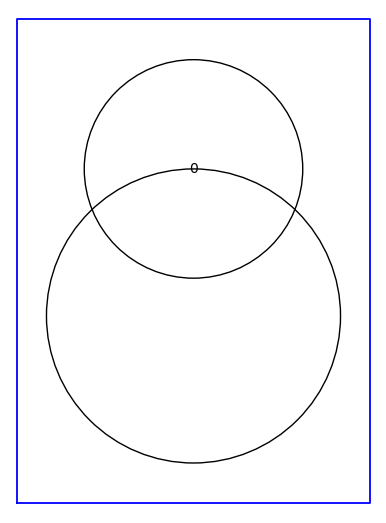

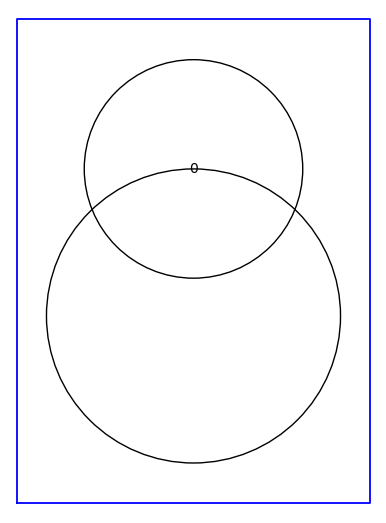

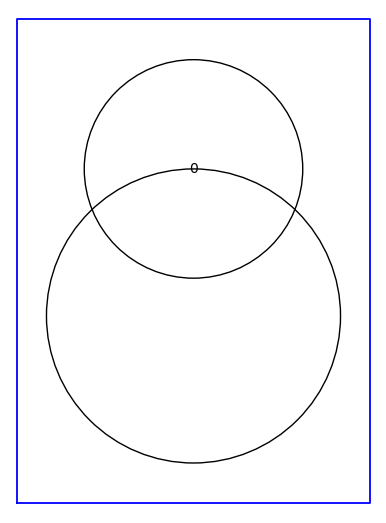

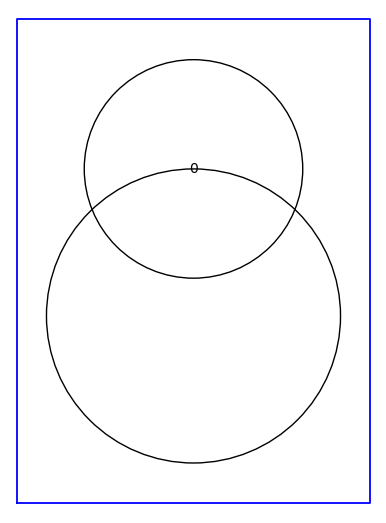

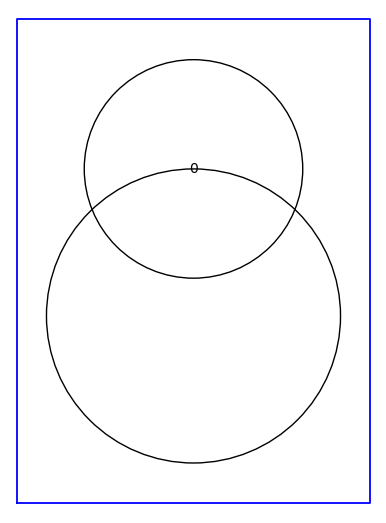

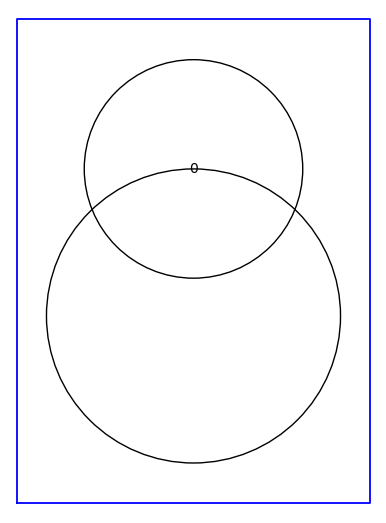

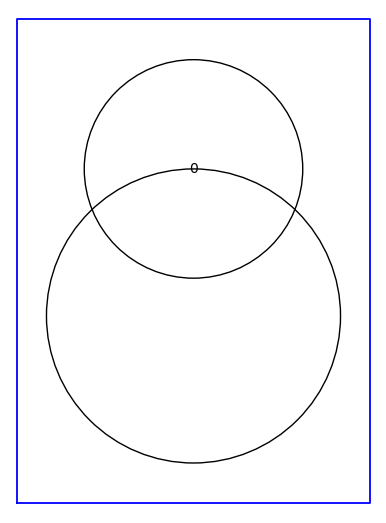

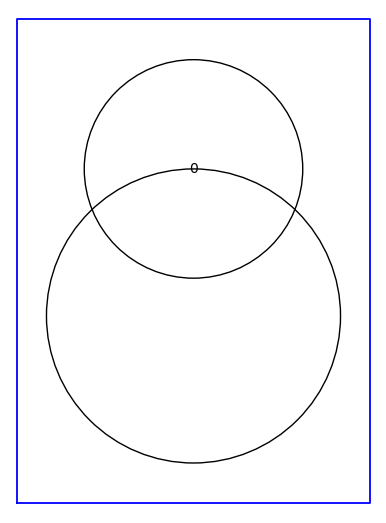

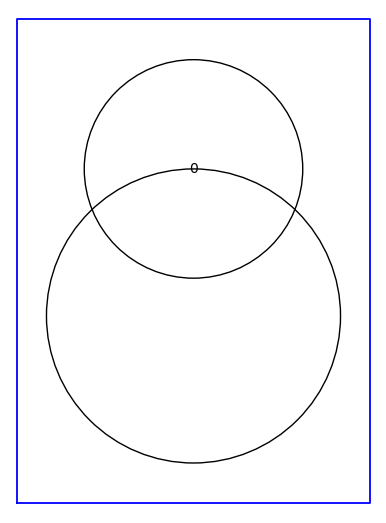

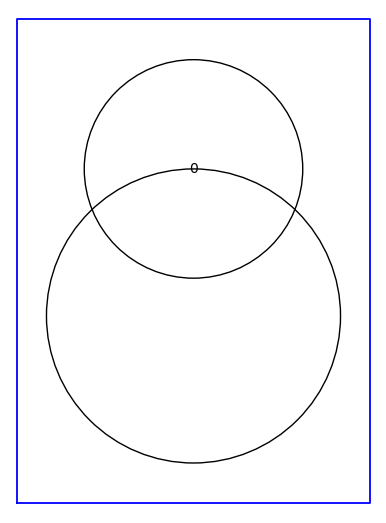

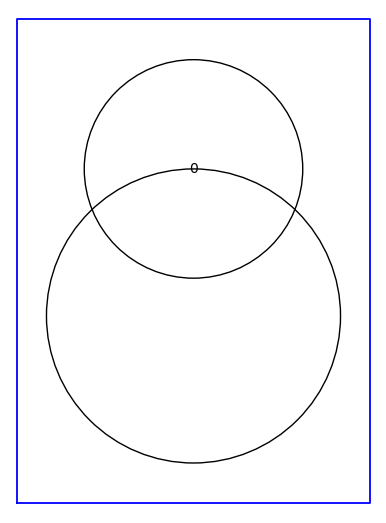

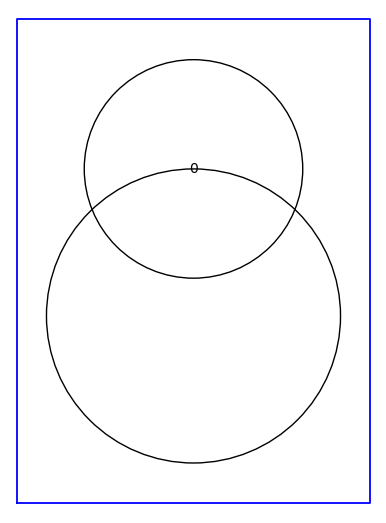

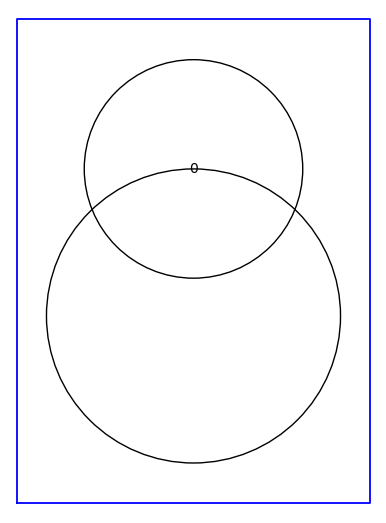

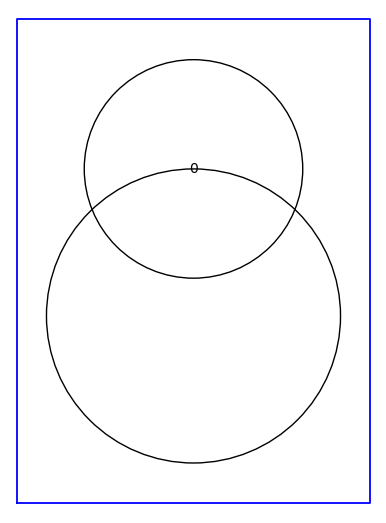

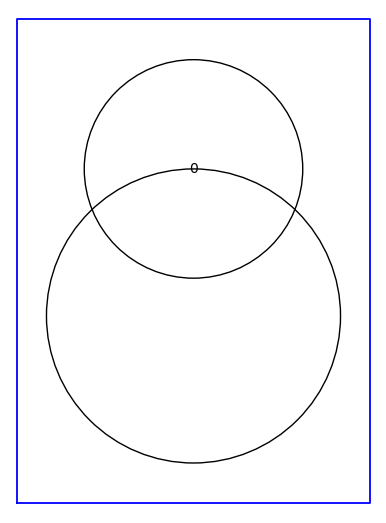

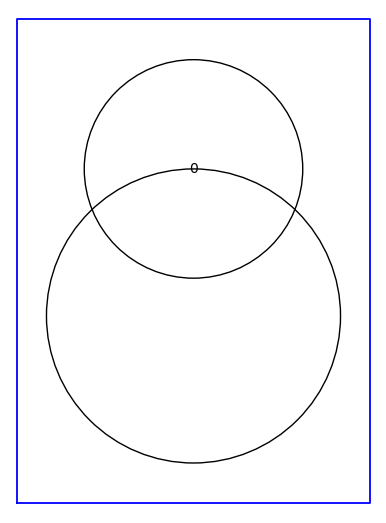

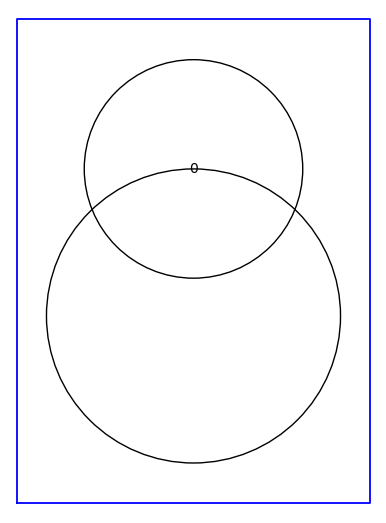

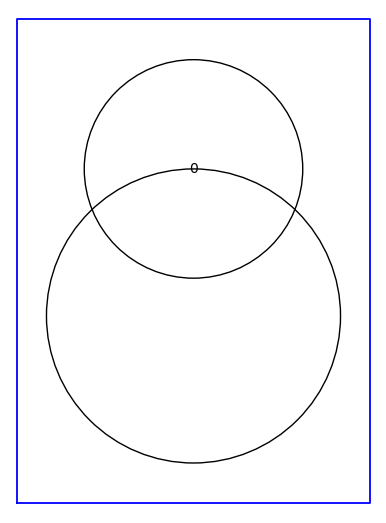

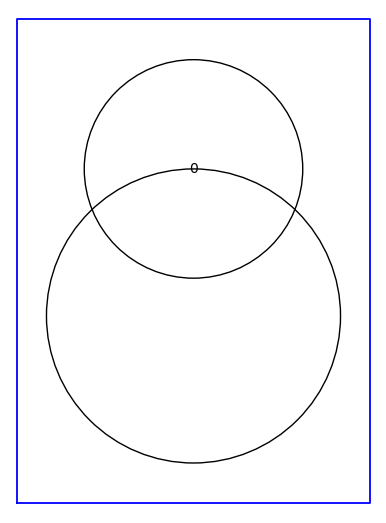

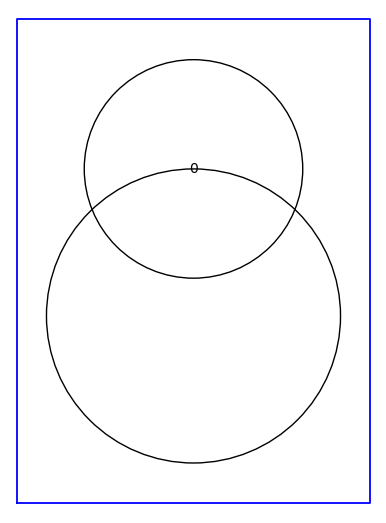

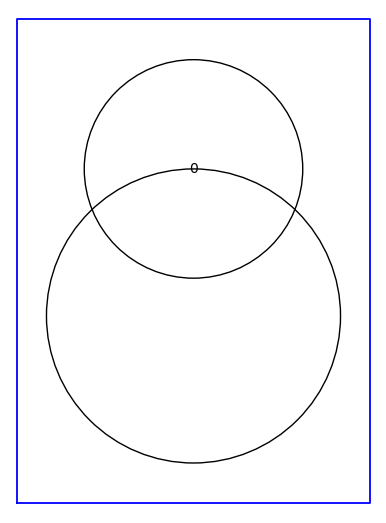

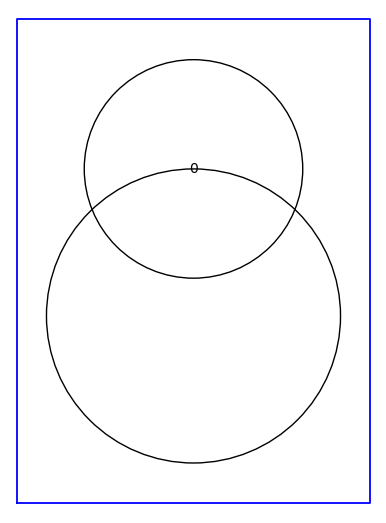

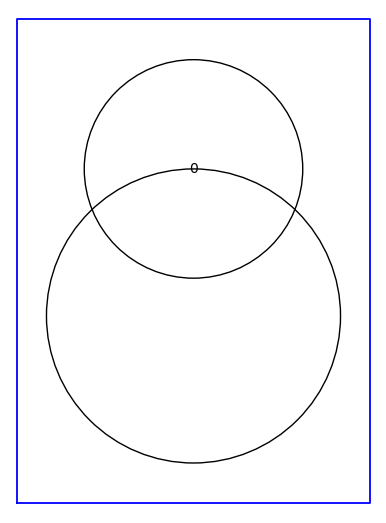

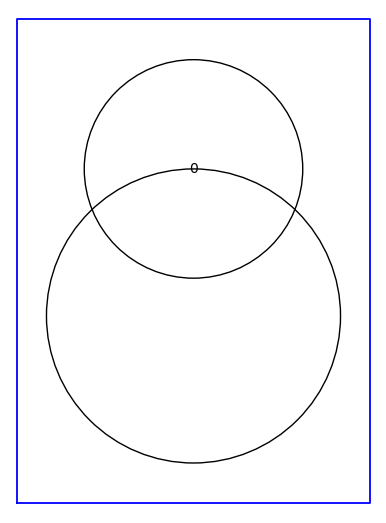

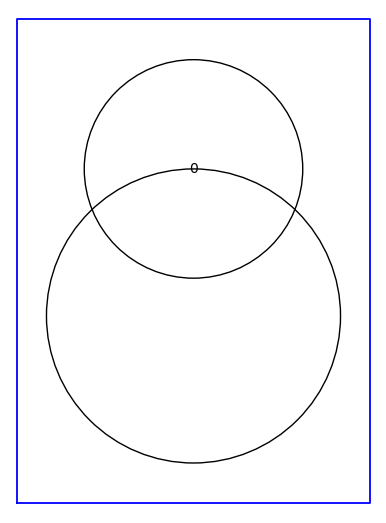

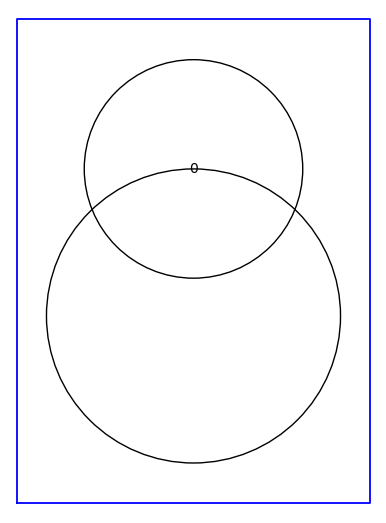

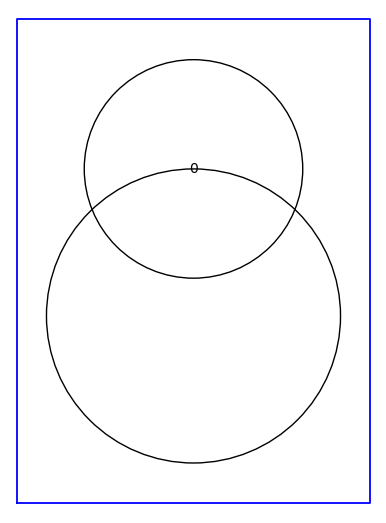

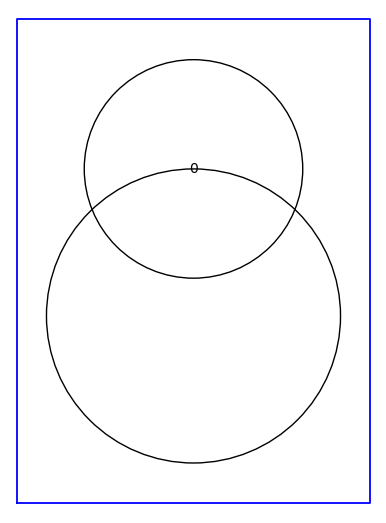

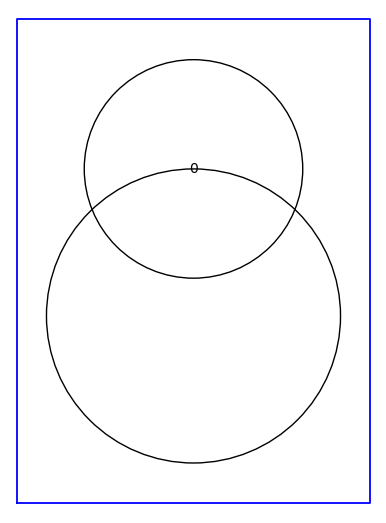

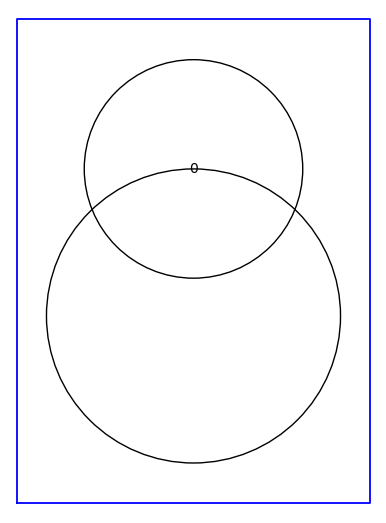

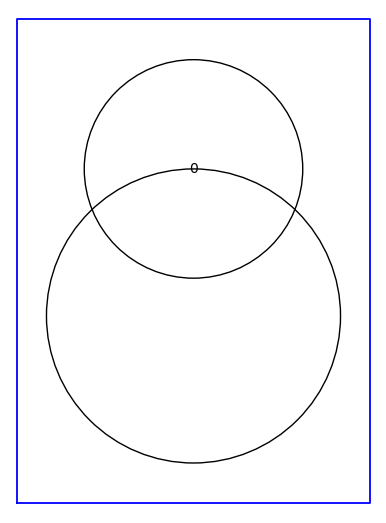

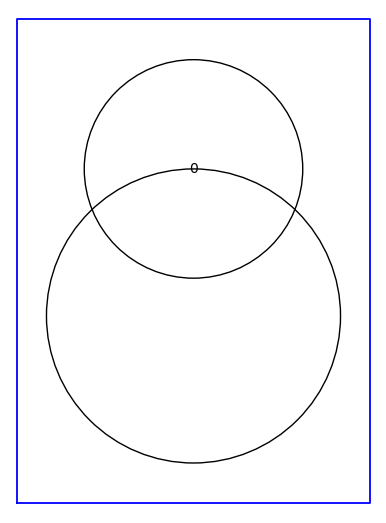

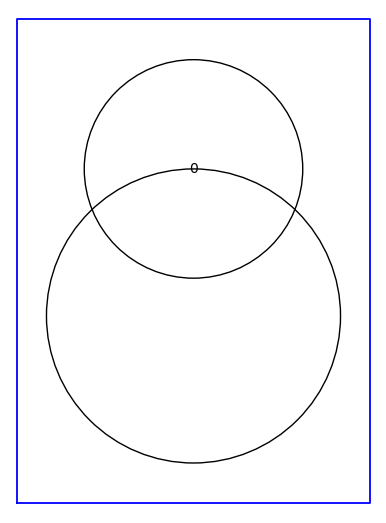

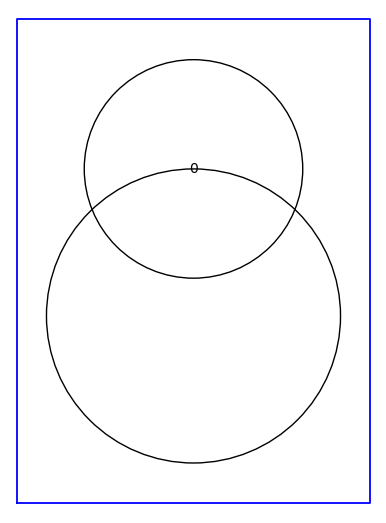

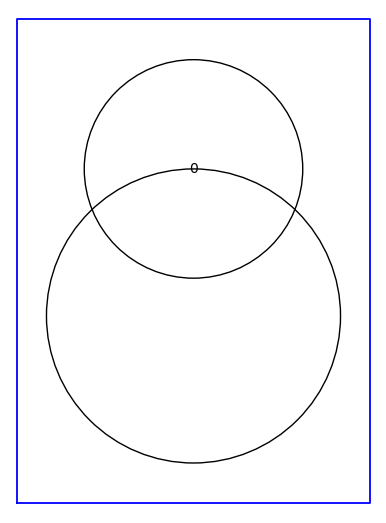

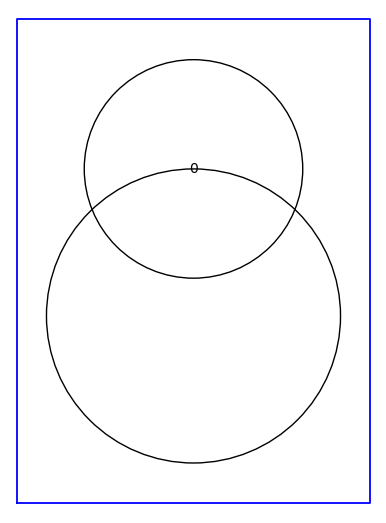

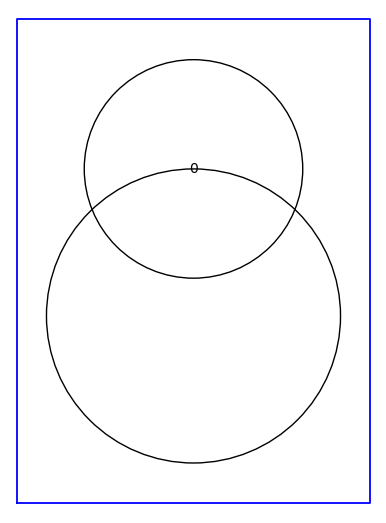

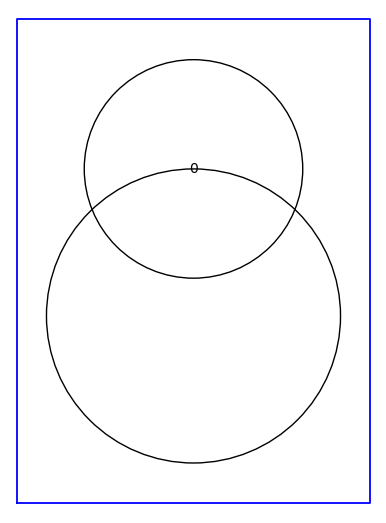

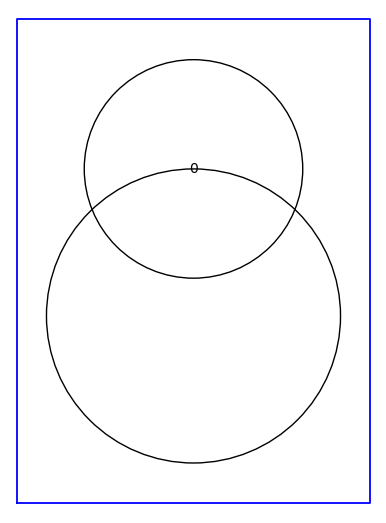

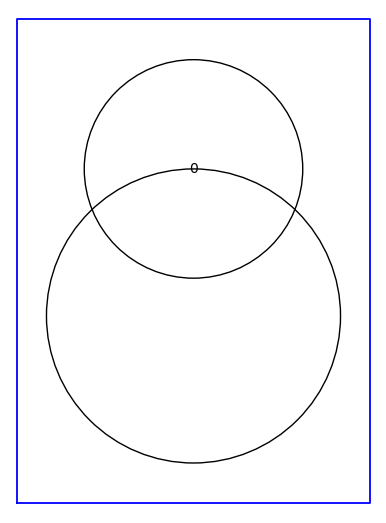

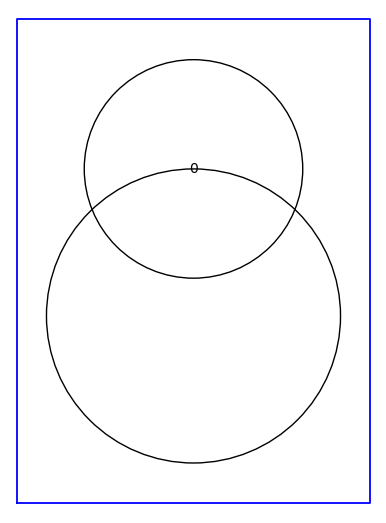

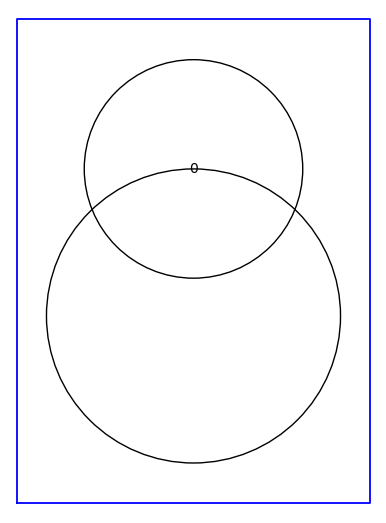

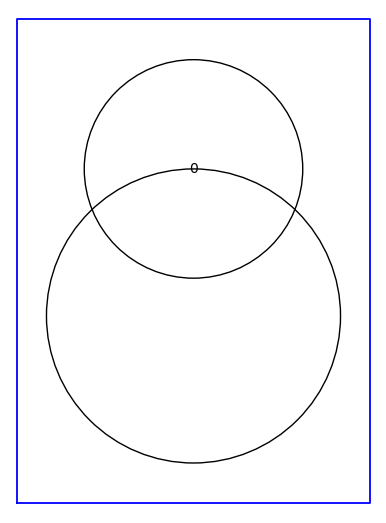

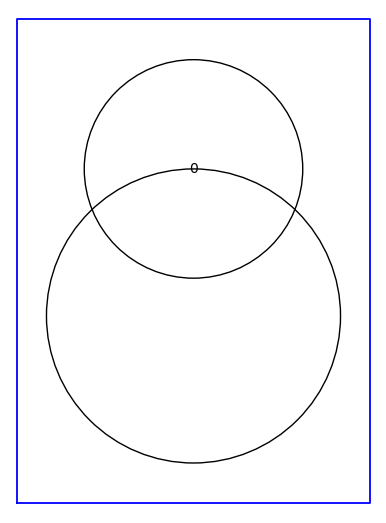

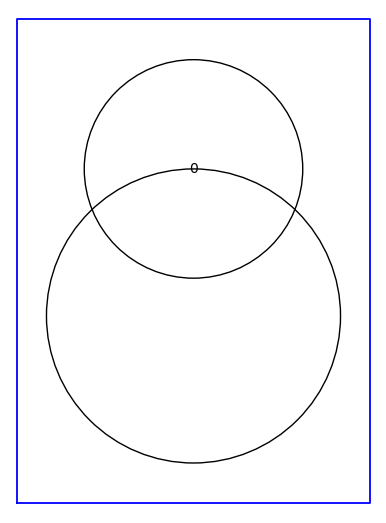

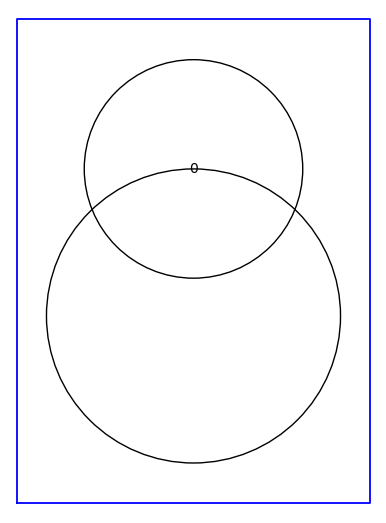

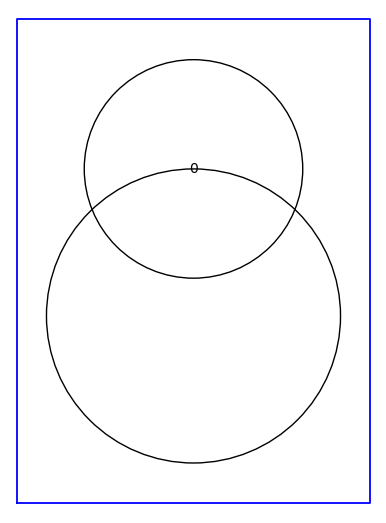

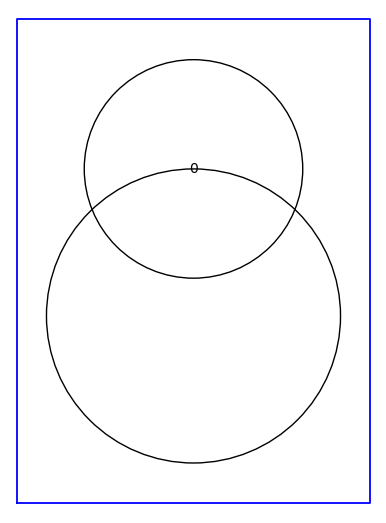

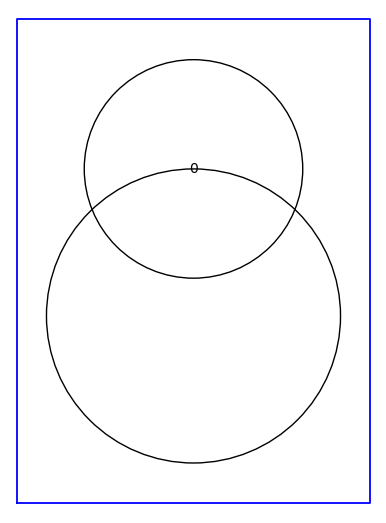

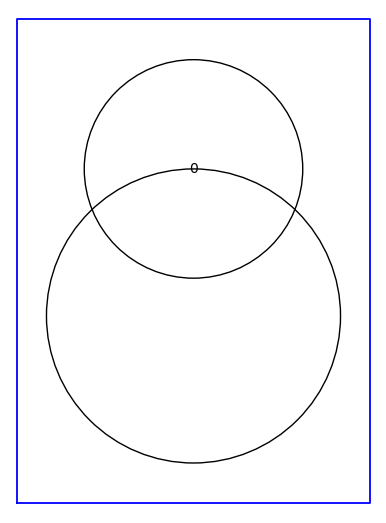

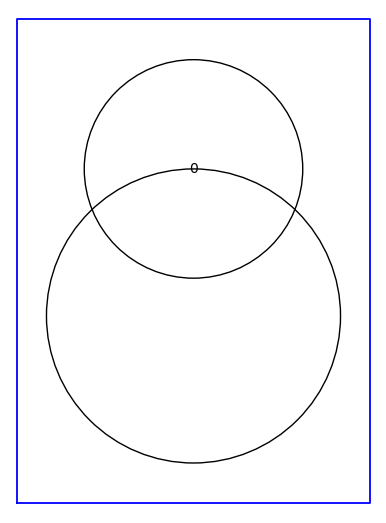

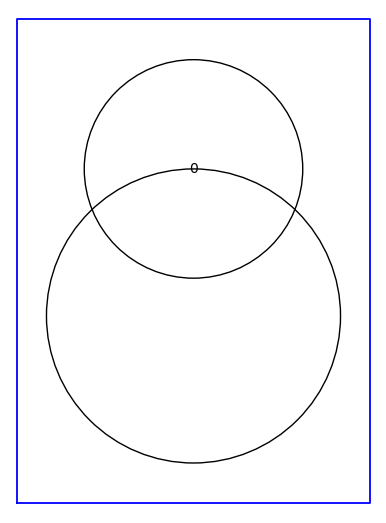

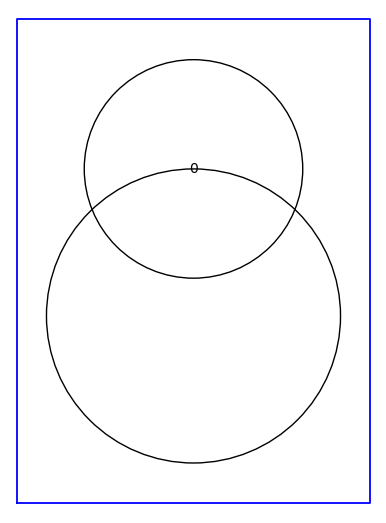

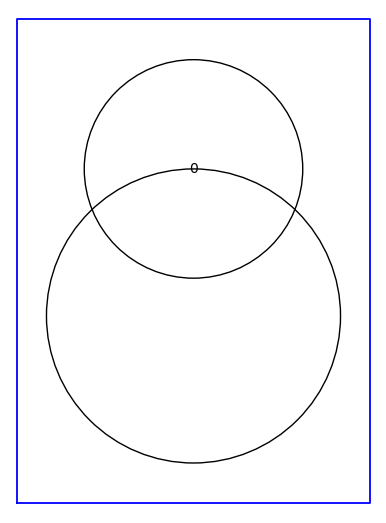

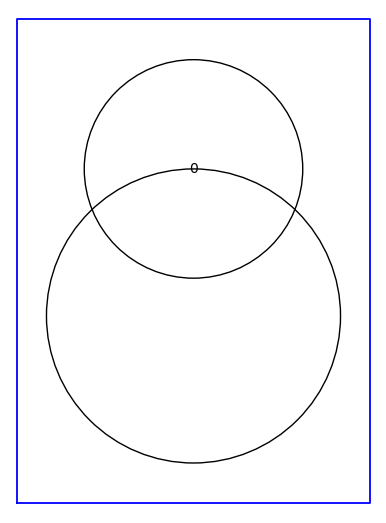

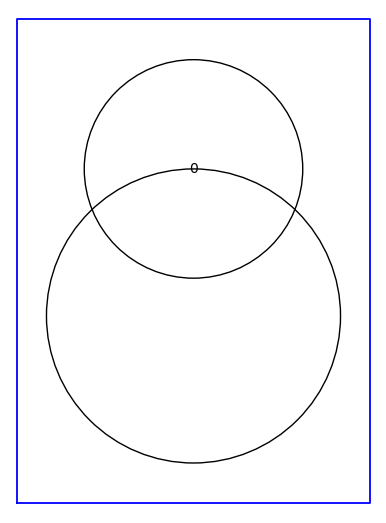

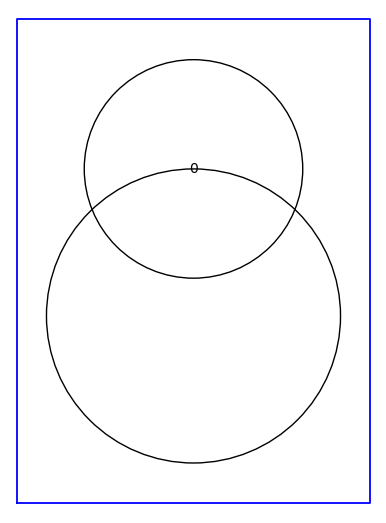

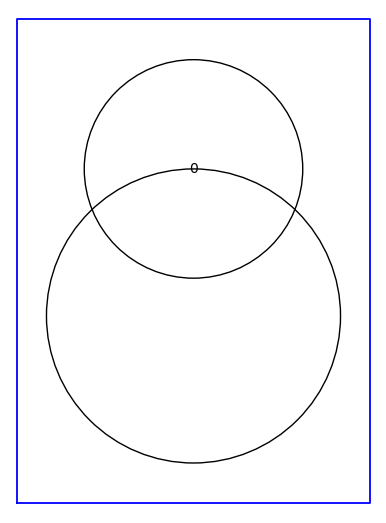

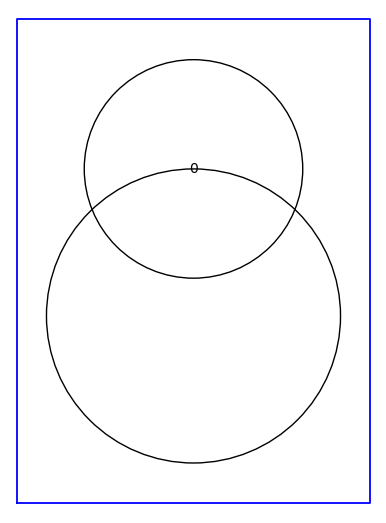

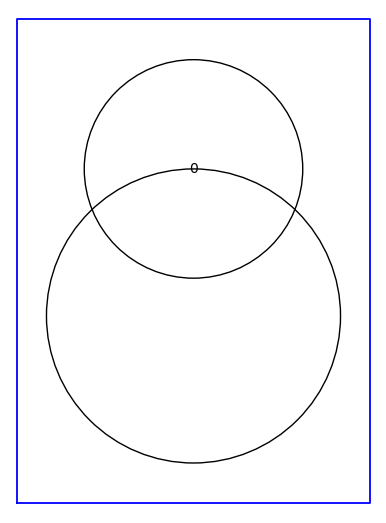

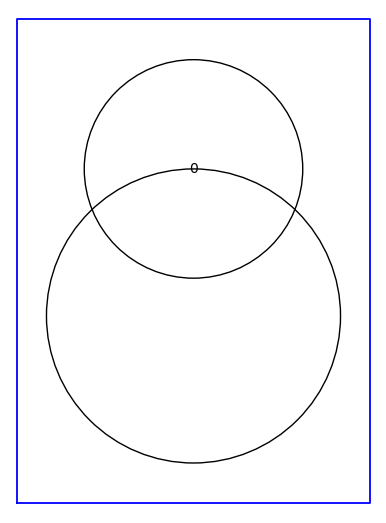

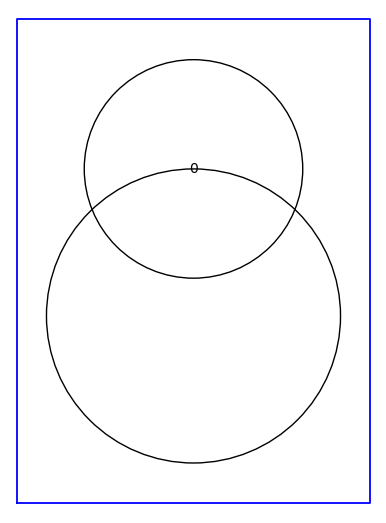

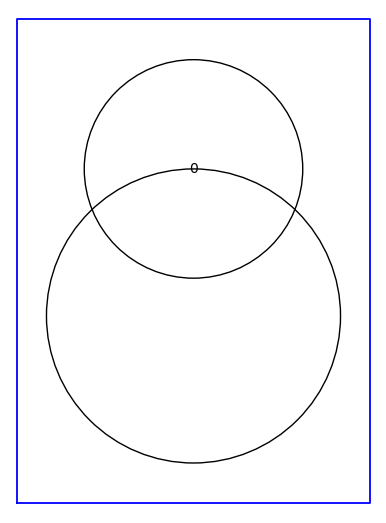

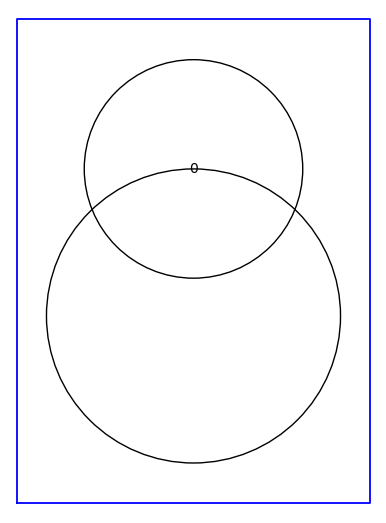

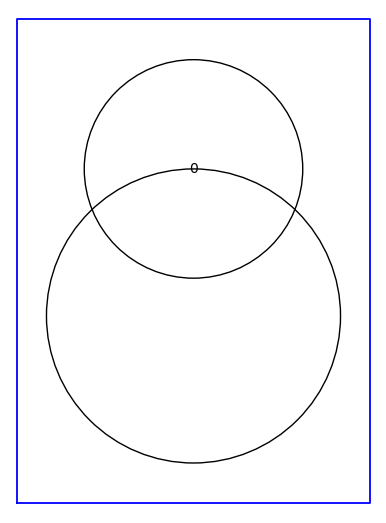

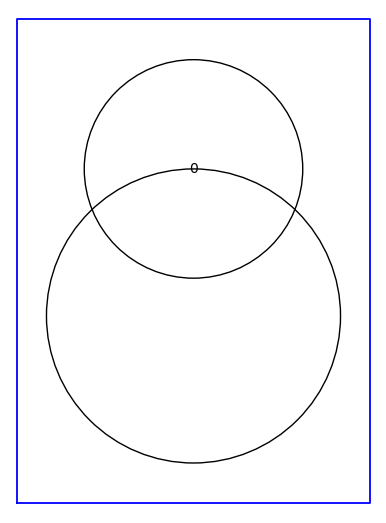

In [40]:
for graph in graphs:
    show(plot(graph,figsize=8,vertex_color = "white",title_pos=(0.5,-0.05),fontsize = 14,graph_border=True))

In [64]:
def degree(f) :
     return  max(f.denominator().degree() , f.numerator().degree());   

def create_functions_file(FF,b):
    """
    Creat a file that contains functions over finite fields with height <= b
    
    Input :
    - FF: Finite field
    - b: The height
    
    Output:
    file that contains functions over finite fields with height <= b
    
    """
    K = GF(FF)
    F.<t> = FunctionField(K)
    KF = F.constant_field()
    elements_set = set();
    if(b==0):
        return [F(el) for el in list(KF)]
    else:
        P = ProjectiveSpace((b*2)+1,KF)
        l = list(P.rational_points())
        n = len(l[0])
        for i in l:
            w1 =(list(i)[0:n/2])
            w2 =(list(i)[n/2:n])
            P = F(1).numerator().parent()
            if(P(w2) != 0 and degree(P(w1)/P(w2)) <= b):
                elements_set.add(F(P(w1)/P(w2)))
    elements_list = list(elements_set)                
    with open('height-' + str(b) + '.txt', 'w') as f:
        f.writelines("%s\n" % str(func) for func in elements_list)

In [42]:
%%time
create_functions_file(2,2)

CPU times: user 112 ms, sys: 5.24 ms, total: 118 ms
Wall time: 122 ms


In [67]:
%%time
create_functions_file(5,2)
graphs = generate_list("height-2.txt")
my_l = []
with open("height-2.txt") as file_in:
        for func_str in file_in:
            # converte the string to a mathematical expression
            func_eval = sage_eval(func_str,locals={'x':x , 't':t})
            my_l.append(str(func_eval))
i = 0
for graph in graphs:
    if graph.order() > 1 :
        show(plot(graph , figsize=8 ,vertex_color = "white",title = '$' + 'x^2 + ' + my_l[i] + '$' ,title_pos=(0.5,-0.05) , fontsize = 14,graph_border=True))
        i += 1

Interrupting Singular...


SingularError: Singular error:
   ? unknown option `set`
   ? unknown option `sage618678`
   ? error occurred in or before STDIN line 11: `option(set,sage618678);`

In [56]:

with open("height-2.txt") as file_in:
        for func_str in file_in:
            # converte the string to a mathematical expression
            func_eval = sage_eval(func_str,locals={'x':x , 't':t})
            func_lst.append(str(func_eval))



In [60]:
for i in range(0,len(func_lst)):
    print('$' + 'x^2 + ' + func_lst[i] + '$')

$x^2 + 0$
$x^2 + 1$
$x^2 + 2$
$x^2 + (2*t + 1)/(t^2 + 2*t + 2)$
$x^2 + (t^2 + t)/(t^2 + 2*t + 2)$
$x^2 + t$
$x^2 + (t^2 + t + 1)/(t^2 + 2*t + 1)$
$x^2 + t + 1$
$x^2 + t + 2$
$x^2 + (2*t^2 + t)/(t^2 + t + 2)$
$x^2 + t^2$
$x^2 + (t^2 + 1)/(t^2 + 2*t + 1)$
$x^2 + t^2 + 1$
$x^2 + t^2 + 2$
$x^2 + t^2 + t$
$x^2 + 1/(t^2 + 2*t + 2)$
$x^2 + (2*t^2 + 2)/(t^2 + 2*t + 2)$
$x^2 + 2/(t^2 + 2*t + 1)$
$x^2 + 1/(t^2 + t)$
$x^2 + (2*t^2 + 2)/(t^2 + t)$
$x^2 + t^2 + t + 1$
$x^2 + (t^2 + 2*t + 2)/t^2$
$x^2 + (t^2 + 2*t)/(t^2 + 2*t + 2)$
$x^2 + t^2 + t + 2$
$x^2 + (2*t^2 + 2*t + 2)/(t^2 + 2*t + 1)$
$x^2 + (t + 1)/t$
$x^2 + (t^2 + t + 2)/(t^2 + 2*t + 2)$
$x^2 + (t^2 + t + 2)/(t^2 + t)$
$x^2 + (2*t^2 + t + 2)/(t^2 + t + 2)$
$x^2 + t^2/(t^2 + 2*t + 2)$
$x^2 + (t^2 + t + 2)/t$
$x^2 + (2*t^2 + t + 2)/(t + 2)$
$x^2 + 2*t^2/(t^2 + t + 2)$
$x^2 + (t^2 + t)/(t^2 + t + 2)$
$x^2 + (t^2 + t)/(t + 2)$
$x^2 + (2*t^2 + t)/(t^2 + 1)$
$x^2 + (t^2 + 2)/(t^2 + 2*t + 2)$
$x^2 + (t^2 + 1)/(t^2 + t + 1)$
$x^2 + (t^2 + 1)/(t + 